# Multiple Agreement Experiments (PVE)

In [1]:
import pickle
from re import X
from scipy.optimize import minimize
import math
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import random
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from uwTOPSIS.uwTOPSIS import *
import geopandas as gpd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display
from sklearn.preprocessing import normalize
from functools import partial
import time
from joblib import Parallel, delayed
from multiprocessing import Pool
import seaborn as sns
from scipy.stats import entropy

# import tensorflow as tf

# Data Preparation & Function Declaration

In [2]:
# FUNCTIONS DATA PREPARATION

def concat_columns(row):
    return np.array(row[['kosten', 'land', 'leiding', 'samen', 'zelf']])

def divide_by_sum(arr):
    return arr / arr.sum()

In [3]:
file_path = "Datasets/VO_matrices.pkl"

with open(file_path, 'rb') as f:
    data = pickle.load(f)


for key, df in data.items():
    data[key] = df.values.transpose()

for key, df in data.items():
    data[key] = df.flatten()


df_x0 = pd.DataFrame(list(data.items()), columns=['Keys', 'Values'])

df_x0['x0'] = df_x0['Values']

df_x0.drop(columns=['Values'], inplace=True)


df_x0['id'] = df_x0['Keys']
df_x0.drop(columns=['Keys'], inplace=True)

file_path = "Datasets/complete_rankings.csv"

df_omega = pd.read_csv(file_path)

df_omega['omega'] = df_omega.apply(concat_columns, axis=1)

df_omega.drop(columns=['kosten', 'land', 'leiding', 'samen', 'zelf'], inplace=True)

df_omega['omega_weights'] = df_omega['omega'].apply(divide_by_sum)

df_omega.drop(columns=['omega'], inplace=True)


df = pd.merge(df_x0, df_omega, on='id')
names = np.stack(df['id'].values)
x0_values = df['x0'].values
omega_values = df['omega_weights'].values

x0 = np.stack(x0_values)
omega = np.stack(omega_values)

In [4]:
### FUNCIONES DE UTILIDAD ######
def util_i(x, x0i, wi):
  utilid = 0
  V = len(wi) # Número de criterios
  AV = len(x) # Criterios por acciones
  for j in range(0,AV):
    utilid += -((x[j] - x0i[j]) / (1 - wi[j%V]))**2
  return utilid

def global_utility(x, x0, w):
  n = len(x0) 
  gl_ut = 0
  for i in range(0,n):
    gl_ut += util_i(x,x0[i],w[i])
  return gl_ut/len(x0)

In [5]:
#### FUNCIONES AUXILIARES VARIAS

def show_connected_components(C):
    components = list(nx.connected_components(C))

    for i, component in enumerate(components):
        print(f"Component {i + 1} nodes:", component)

    pos = nx.spring_layout(C, seed=42, k=1)  
    pos_adjusted = {node: (x, y + 0.2) for node, (x, y) in pos.items()}

    plt.figure(figsize=(10, 6))

    for i, component in enumerate(components):
        nx.draw(C.subgraph(component), pos_adjusted, label=f'Component {i + 1}', with_labels=True, node_color=[i] * len(component), cmap=plt.cm.Set1, font_color='white', node_size=300)

    nx.draw(C, pos_adjusted, node_size=50, edge_color='grey', with_labels=False)

    plt.legend()
    plt.show()
    
    return components

def round_3f (x):
  return round(x,3)

def get_subarray_from_indices (indices,arr):
     return [arr[i] for i in indices]

  
def replace_similar_vectors(arr):
    replaced = [False] * len(arr)
    
    for i in range(len(arr)):
        if not replaced[i]:
            for j in range(i + 1, len(arr)):
                if not replaced[j]:
                    distance = np.linalg.norm(arr[i] - arr[j])
                    if distance <  0.01 + 1e-1:
                        arr[j] = arr[i] 
                        replaced[j] = True  
    return arr


def utilidad_individual_grupo(exp, num_iter, x0, omega):
    final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(exp[:, num_iter-1, :])), axis=0)
    indices_grupos = []
    aprox_execution = replace_similar_vectors(np.vectorize(round_3f)(exp[:, num_iter-1, :]))
    
    for matrix in final_matrices:
        indices_grupo = [i for i, exec in enumerate(aprox_execution) if np.array_equal(exec, matrix)]
        indices_grupos.append(indices_grupo)

    omega_grupos = []
    x0_grupos = []
    
    for indices in indices_grupos:
        omega_grupos.append(omega[indices])
        x0_grupos.append(x0[indices])
    all_data = pd.DataFrame()
    
    for index, (x0_grupo, omega_grupo) in enumerate(zip(x0_grupos, omega_grupos)):
        n = len(x0_grupo)  # Number of agents in the group
        if n>0:
            utility_values = [util_i(final_matrices[index], x0_grupo[i], omega_grupo[i]) for i in range(n)]
            
            # Temporary DataFrame to store group's data
            temp_df = pd.DataFrame({'Group': [f'Group {index + 1}'] * n, 'Individual Utility': utility_values})
            all_data = pd.concat([all_data, temp_df], ignore_index=True)
    
    sns.violinplot(x='Group', y='Individual Utility', data=all_data, palette='pastel') 


    means = all_data.groupby('Group')['Individual Utility'].mean().reset_index()
    for index, row in means.iterrows():
        plt.scatter(x=index, y=row['Individual Utility'], color='red', s=100)  # s is the size of the dot

    plt.xlabel('Groups')
    plt.ylabel('Individual Utility')
    plt.show()

def agreement_optimum_distance(exp, num_iter, x0, omega):


    final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(exp[:,num_iter-1,:])),axis=0)

    indices_grupos = []
    aprox_execution = replace_similar_vectors(np.vectorize(round_3f)(exp[:,num_iter-1,:]))
    for matrix in final_matrices:
        indices_grupo = []
        i=0
        for exec in aprox_execution:
            if np.array_equal(exec, matrix):
                indices_grupo += [i]
            i+=1
        indices_grupos += [indices_grupo]

    omega_grupos = []
    x0_grupos = []
    
    for index in indices_grupos:
      omega_grupos += [get_subarray_from_indices(np.unique(index),omega)]
      x0_grupos += [get_subarray_from_indices (np.unique(index),x0)]
        
    for index, (x0_grupo, omega_grupo) in enumerate(zip(x0_grupos, omega_grupos)):
        x_init = np.repeat(0.0, len(x0[0]))

        result = optimize.minimize(lambda x: -global_utility(x, x0_grupo, omega_grupo), x_init,method='BFGS')
        maximum_value = -result.fun
        maximum_coordinates = result.x
        print("=========================================================================================")
        print("Group:", index)
        print("Maximum value:", maximum_value)
        print("Coordinates of the maximum:", maximum_coordinates)
        distance = np.linalg.norm(final_matrices[index] - maximum_coordinates)
        print("Distance between the vectors:", distance)
        print("=========================================================================================")


def get_dynamic_labels(data):
    unique_arrays = {}
    current_label = 0

    labels = []

    for arr in data:
        arr_tuple = tuple(arr)

        if arr_tuple not in unique_arrays:
            unique_arrays[arr_tuple] = current_label
            current_label += 1
        labels.append(unique_arrays[arr_tuple])
    return labels

def perplexity (exp, num_iter):
    
    final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(exp[:,num_iter-1,:])),axis=0)
    
    num_clusters = len(final_matrices)

    labels = get_dynamic_labels(replace_similar_vectors(np.vectorize(round_3f)(exp[:,num_iter-1,:])))

    cluster_sizes = np.bincount(labels, minlength=num_clusters)
    total_points = len(labels)
    cluster_probabilities = cluster_sizes / total_points

    cluster_entropy = entropy(cluster_probabilities, base=2)
    perplexity = 2 ** cluster_entropy

    print(f"Cluster Probabilities: {cluster_probabilities}")
    print(f"Entropy: {cluster_entropy}")
    print(f"Perplexity: {perplexity}")

    return perplexity

In [6]:
### FUNCIONES DE UTILIDAD ###

def util_i(x, x0i, wi):
  utilid = 0
  V = len(wi) # Número de criterios
  AV = len(x) # Criterios por acciones
  for j in range(0,AV):
    utilid += -((x[j] - x0i[j]) / (1 - wi[j%V]))**2
  return utilid


def gradiente_util_i(x, x0i, wi):
  AV = len(x) # Criterios por acciones
  V = len(wi) # Número de criterios
  gradiente_util = np.zeros(AV)
  for j in range(0,AV):
    gradiente_util[j] = -2*((x[j]-x0i[j])/((1-wi[j%V])**2))
  return gradiente_util


def gradiente_util(x, x0, omega):
    n, AV = x.shape
    _, V = omega.shape

    gradient = -2 * ((x - x0) / ((1 - omega[:, np.arange(AV) % V]) ** 2))

    return gradient



def global_utility(x, x0, w):
  n = len(x0) # Este error, antes estaba poniendo x, lo suyo es poner x0
  gl_ut = 0
  for i in range(0,n):
    gl_ut += util_i(x,x0[i],w[i])
  return gl_ut/len(x0)

  ### GRÁFICA EVOLUCIÓN POR ITERACIÓN ###

def plot_consensus(x):
  for i in range(0,len(x[0,0,:])):
    plt.plot(np.transpose(x[:,:,i]))
    plt.xlabel('#iter')
    plt.ylabel('$x_'+str(i)+'$')
    plt.show()

    ### CÁLCULO PARÁMETROS STEPSIZE ###

def beta (W):
  n = len(W)
  matrix = W - np.full((n, n), 1/n)
  return max(np.linalg.svd(matrix, compute_uv=False))

  ### GENERAR MATRIZ W A PARTIR DEL EPSION OBTENIDO POR EL GRADO DE LOS NODOS Y LA MATRIZ DE ADYACENCIA ###

def gen_W_eps (epsilon, A):
  n = len(A)
  count = 0
  W = np.zeros((n, n))
  for i in range(0,n):
    for j in range(0,n):
      if A[i,j] == 1 and W[i,j]==0:
        W[i,j] = epsilon
        W[j,i] = epsilon
        count += 1
  for i in range(0,n):
    W[i,i] = 1- sum(W[i])
  return W

### GENERAR RED TENIENDO LOS NOMBRES DE LOS NODOS, LOS X0 INICIALES Y EL RADIO DE ENLACE ###

def generate_network_nx (names, x0, mindist):
  n = len(x0)
  G = nx.Graph()
  for node_name in names:
    G.add_node(node_name)
  for i in range(0,len(x0)):
    for j in range(0,len(x0)):
      d = np.linalg.norm(x0[i]-x0[j],2)
      if d<mindist[i] and d<mindist[j] and i != j:
        G.add_edge(names[i], names[j])
  return G


def generate_network_nx_eficient(names, x0, mindist):
    n = len(x0)
    G = nx.Graph()

    G.add_nodes_from(names)

    distances = np.linalg.norm(x0[:, np.newaxis] - x0, axis=2)

    mask = (distances < mindist[:, np.newaxis]) & (distances < mindist)
    np.fill_diagonal(mask, False) 
 
    edge_indices = np.argwhere(mask)

    for i, j in edge_indices:
        G.add_edge(names[i], names[j])
    
    return G


def round_3f (x):
  return round(x,3)

def get_subarray_from_indices (indices,arr):
     return [arr[i] for i in indices]

def PHI (X):
  return np.concatenate(X.to_numpy())

def PHI_inv (x, V):
 return np.array_split(x,V)


def alpha_function (G,epsilon, L):
  W = gen_W_eps(epsilon, nx.adjacency_matrix(G).toarray())
  I = np.identity(W.shape[0])
  hat_W = (I+W)/2
  min_eigenvalue = np.min(np.linalg.eigvals(hat_W))
  alpha = ((2*min_eigenvalue)/L)*0.9
  return alpha

def get_connected_components_list(graph, epsilon, L):
    connected_components = list(nx.connected_components(graph))
    num_components = len(connected_components)

    components_list = []

    for i in range(num_components):
        component_data = []
        component = connected_components[i]
        subgraph = graph.subgraph(component)
        component_data += [subgraph]
        component_data +=[alpha_function (subgraph,epsilon, L),1]
        components_list += [component_data]
    return components_list

def adjacency_to_incidence(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]
    num_edges = np.sum(adjacency_matrix) // 2 

    incidence_matrix = np.zeros((num_nodes, num_edges), dtype=int)

    edge_index = 0
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                incidence_matrix[i][edge_index] = 1
                incidence_matrix[j][edge_index] = 1
                edge_index += 1

    return incidence_matrix


def laplacian_matrix(adjacency_matrix):

    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

    laplacian = degree_matrix - adjacency_matrix

    return laplacian


def get_optimal_eps(G):
      Laplacian = laplacian_matrix(nx.adjacency_matrix(G).toarray())
      eigenvalues = np.linalg.eigvals(Laplacian)
      sorted_eigenvalues = np.sort(eigenvalues)

      largest_eigenvalue = sorted_eigenvalues[-1]

      second_smallest_eigenvalue = sorted_eigenvalues[1]
      epsilon = 2/(largest_eigenvalue+second_smallest_eigenvalue)

      return epsilon

def get_stepsize_alpha_from_conn_component (G, omega, epsilon):
    L = 2/((1-np.max(omega))**2)
    W = gen_W_eps(epsilon, nx.adjacency_matrix(G).toarray())
    I = np.identity(W.shape[0])
    hat_W = (I+W)/2
    IplusW = I+W
    min_eigenvalue = np.min(np.linalg.eigvals(hat_W))
    alpha = ((2*min_eigenvalue)/L)*0.9
    return alpha

def get_connected_components(graph):
    connected_components = list(nx.connected_components(graph))
    num_components = len(connected_components)
    components_list = []
    for component in connected_components:
        components_list += [graph.subgraph(component)]
    return components_list

def objective_function_projection(x, point):
    return np.linalg.norm(x - point)**2


def euclidean_projection_to_simplex(point):
    """
    Calculate the Euclidean projection of a point onto the simplex.

    Parameters:
    - point: The point to project onto the simplex.

    Returns:
    - The projected point onto the simplex.
    """


    # Define the constraints: sum of elements equals 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Initialize the initial guess for the optimization
    x0 = np.ones_like(point) / len(point)

    # Perform the optimization to find the point in the simplex closest to the given point
    result = minimize(objective_function_projection, x0, args=(point,), constraints=constraints, bounds=[(0, 1)]*len(point))

    # Return the projected point
    return result.x



def euclidean_projection_to_range(point, range_max):
    """
    Calculate the Euclidean projection of a point onto the simplex.

    Parameters:
    - range_max: maximum point of the evaluation range 0-range_max
    - point: The point to project onto the simplex.

    Returns:
    - The projected point onto the simplex.
    """

    # Define the constraints: sum of elements equals 1

    # Initialize the initial guess for the optimization
    x0 = np.ones_like(point) / len(point)

    # Perform the optimization to find the point in the simplex closest to the given point
    result = minimize(objective_function_projection, x0, args=(point,), bounds=[(0, range_max)]*len(point))

    # Return the projected point
    return result.x



def round_2f (x):
  return round(x,2)


def replace_similar_vectors(arr):
    replaced = [False] * len(arr)

    for i in range(len(arr)):
        if not replaced[i]:
            for j in range(i + 1, len(arr)):
                if not replaced[j]:
                    distance = np.linalg.norm(arr[i] - arr[j])
  
                    if distance <  0.01 + 1e-1:
                        arr[j] = arr[i] 
                        replaced[j] = True  
    return arr


def distance_analysis (data):
    # Calculamos la distancia máxima entre los valores iniciales:
    dist_mat = squareform(pdist(data, metric="euclidean"))
    print("Maximum distance initial values:"+str(np.max(dist_mat)))
    print("Minimum distance initial values:"+str(np.min(dist_mat)))

    plt.boxplot(dist_mat.flatten())


    # Calcular el primer y tercer cuartil (Q1 y Q3)
    q1 = np.percentile(dist_mat.flatten(), 25)
    q2 = np.percentile(dist_mat.flatten(), 50)
    q3 = np.percentile(dist_mat.flatten(), 75)

    # Calcular el rango intercuartílico (IQR)
    iqr = q3 - q1

    # Calcular el límite inferior para identificar datos atípicos
    lower_bound = q1 - 1.5 * iqr

    print("Q1:", q1)
    print("Q2=Me:", q2)
    print("Q3:", q3)
    print("IQR:", iqr)
    print("Límite inferior para datos atípicos:", lower_bound)
    
    return q1, q2, q3, iqr, lower_bound


# 1. Grupos por X

## 1.1. q1

In [8]:
# Importamos los datos:

file_path = "break_X_PVE_q1.pickle"

with open(file_path, 'rb') as f:
    agreements_X_q1 = pickle.load(f)

file_path = "graph_X_q1.pickle"

with open(file_path, 'rb') as f:
    graph_X_q1 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 118816, 114722, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 118842, 6205, 8259, 118851, 71754, 43084, 8270, 6223, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520, 6473, 

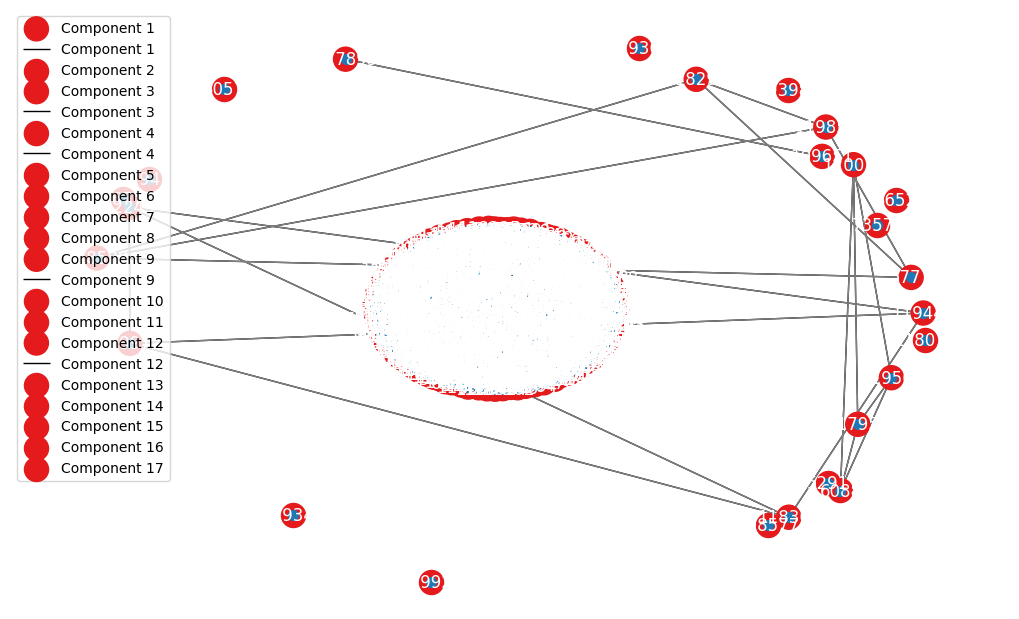

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5420,
  5430,
  5432,
  5433,
  5443,
  5444,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5671,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5730,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5937,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6086,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6223,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,
  6354,
  6361,
  6365,


In [9]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_X_q1)

In [10]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_X_q1[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_X_q1, 2000, x0, omega)

Group: 0
Maximum value: -4.875373759476138e-12
Coordinates of the maximum: [-4.59362466e-09  2.17510664e-07  6.28488856e-08  9.99999806e-01
  6.28488856e-08  4.67267273e-09  2.17510664e-07  9.99999749e-01
 -4.56149241e-09  6.28488855e-08 -4.56149241e-09  1.57969576e-07
  6.28488855e-08  9.99999806e-01  6.28488855e-08  9.99999806e-01
  1.57969576e-07  6.28488855e-08 -1.71528190e-08  6.28488855e-08
  9.99999806e-01  2.17510664e-07  6.28488855e-08  4.67267274e-09
  9.99999749e-01  9.99999806e-01  9.99998804e-01 -1.34855084e-07
  9.99999812e-01 -1.34855084e-07]
Distance between the vectors: 1.4285432732000253e-06
Group: 1
Maximum value: -3.535100374099919e-13
Coordinates of the maximum: [-8.97332872e-09 -7.23702786e-09  1.20779266e-08  1.00000007e+00
  2.59685000e-09 -8.97332872e-09 -7.38961333e-09  9.99999878e-01
 -6.92122188e-09 -2.32409794e-08  9.99999969e-01 -7.90688960e-09
  1.20753460e-08 -7.23116775e-09 -2.32409794e-08 -8.97332872e-09
  1.00000002e+00 -1.38554087e-08 -7.41683095e-09

## 1.2. q2

In [32]:
# Importamos los datos:

file_path = "break_X_PVE_q2.pickle"

with open(file_path, 'rb') as f:
    agreements_X_q2 = pickle.load(f)

file_path = "graph_X_q2.pickle"

with open(file_path, 'rb') as f:
    graph_X_q2 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 108577, 114722, 118816, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 118842, 6205, 8259, 118851, 71754, 43084, 8270, 6223, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520

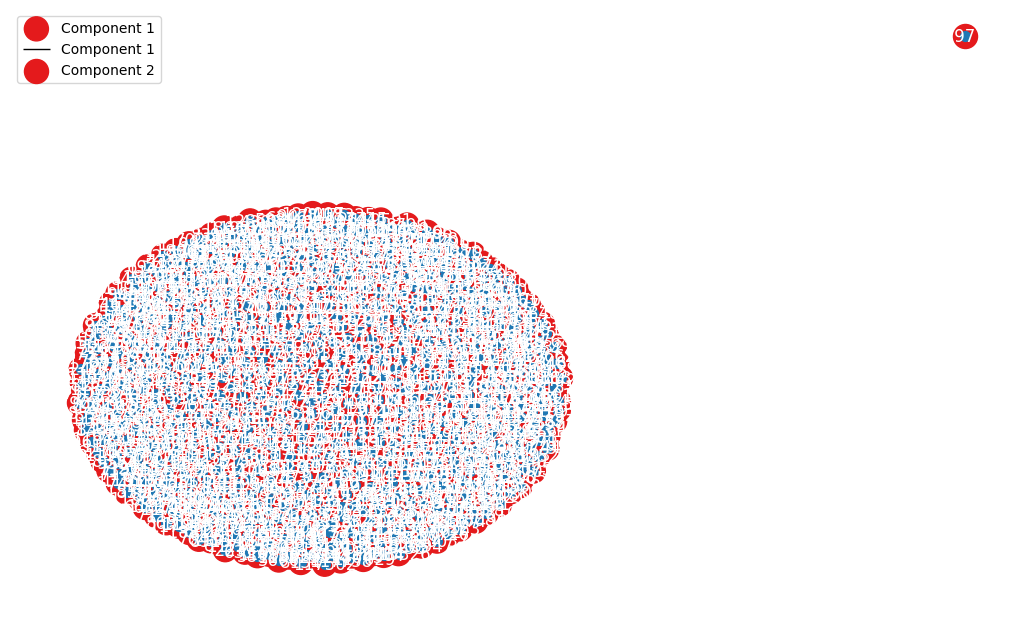

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5291,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5420,
  5430,
  5432,
  5433,
  5443,
  5444,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5671,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5730,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5777,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5937,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6086,
  6088,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6223,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,


In [24]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_X_q2)

In [25]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_X_q2[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_X_q2, 2000, x0, omega)

Group: 0
Maximum value: -7.471711126986711e-13
Coordinates of the maximum: [-4.26076792e-08 -4.26076792e-08  9.99999557e-01 -2.16151617e-09
  1.09499934e-08 -4.26070428e-08 -4.26070428e-08 -8.52501111e-09
  1.00000042e+00  1.15709027e-08 -4.26629651e-08 -4.26629651e-08
 -8.29294607e-09  1.00000042e+00  1.15704119e-08  1.00000004e+00
  1.00000004e+00 -6.72606466e-09 -1.10969401e-08  1.15704151e-08
  4.20343614e-08  4.20343614e-08 -6.72606467e-09 -1.10969401e-08
  1.15704151e-08  4.20343614e-08  4.20343614e-08 -6.72606467e-09
 -1.10969401e-08  1.15704151e-08]
Distance between the vectors: 0.5663597063530731
Group: 1
Maximum value: -5.422905008830636
Coordinates of the maximum: [ 4.62792020e-01  4.79890658e-01  8.52662812e-01  5.07612059e-01
  5.49759936e-01  4.92983057e-01  4.59833630e-01  5.96545333e-01
  6.28279398e-01  7.92755648e-01  8.96529588e-01 -9.58271443e-08
  8.93489191e-01  8.75645352e-01 -6.44992077e-08  6.36997610e-01
  8.83595560e-01  3.24915237e-08  6.72190553e-08  1.2214

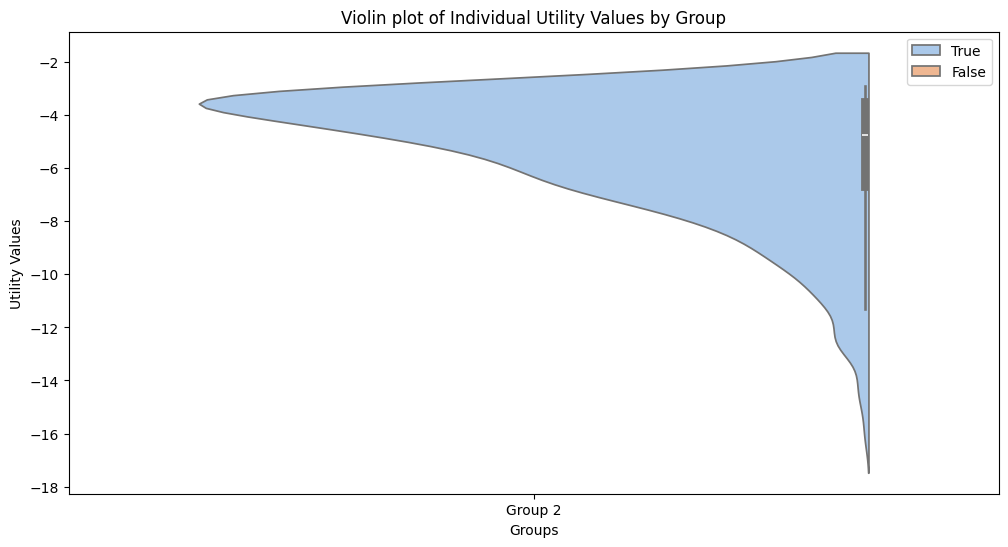

In [33]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_X_q2, 2000, x0, omega)

In [27]:
# Ahora tenemos que evaluar esta clusterización con alguna métrica.
perplexity_X_q2 = perplexity (agreements_X_q2, 2000)

Cluster Probabilities: [0.99885845 0.00114155]
Entropy: 0.012804404487326717
Perplexity: 1.0089148394511642


## 1.3. q3

In [34]:
# Importamos los datos:

file_path = "break_X_PVE_q3.pickle"

with open(file_path, 'rb') as f:
    agreements_X_q3 = pickle.load(f)

file_path = "graph_X_q3.pickle"

with open(file_path, 'rb') as f:
    graph_X_q3 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 108577, 114722, 118816, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 118842, 6205, 8259, 118851, 71754, 43084, 8270, 6223, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520

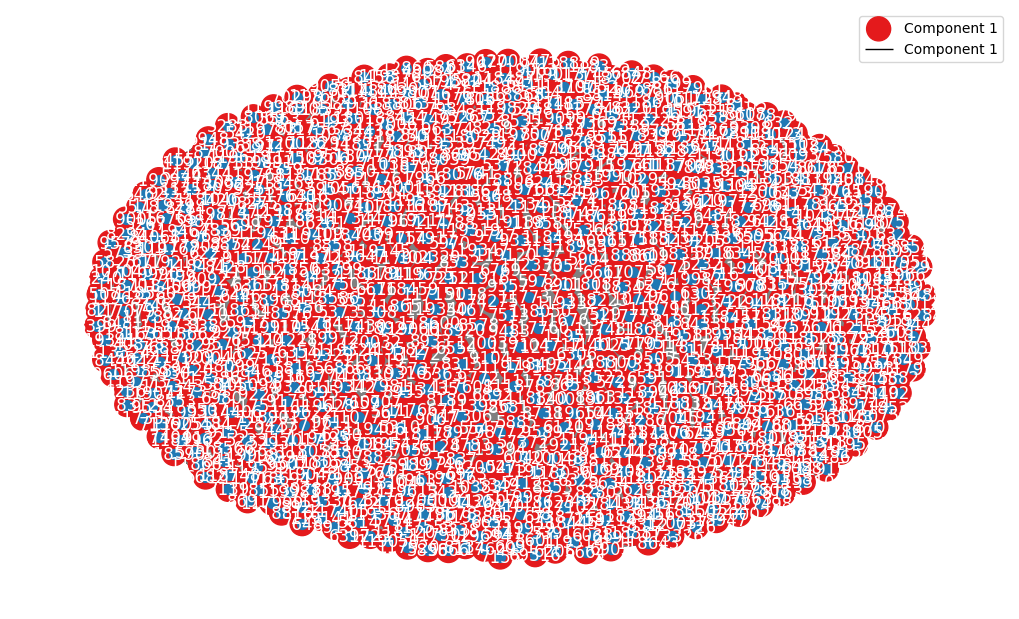

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5291,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5420,
  5430,
  5432,
  5433,
  5443,
  5444,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5671,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5730,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5777,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5937,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6086,
  6088,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6223,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,


In [29]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_X_q3)

In [30]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_X_q3[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_X_q3, 2000, x0, omega)

Group: 0
Maximum value: -5.434495003405593
Coordinates of the maximum: [4.62190323e-01 4.79311580e-01 8.52780606e-01 5.07161065e-01
 5.48919439e-01 4.92341768e-01 4.59276784e-01 5.96061860e-01
 6.28610811e-01 7.91540100e-01 8.95366796e-01 6.70494680e-08
 8.92766377e-01 8.75756715e-01 2.13970323e-07 6.37468676e-01
 8.83737973e-01 6.70494680e-08 1.15688048e-07 2.13970323e-07
 9.17082485e-01 8.61661758e-01 6.70494680e-08 1.15688048e-07
 9.17956318e-01 9.01105740e-01 8.98630702e-01 6.70494680e-08
 9.30065066e-01 2.13970323e-07]
Distance between the vectors: 0.07122790862003159


876


C:\Users\artur\AppData\Local\Temp\ipykernel_10708\1028103871.py:99: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


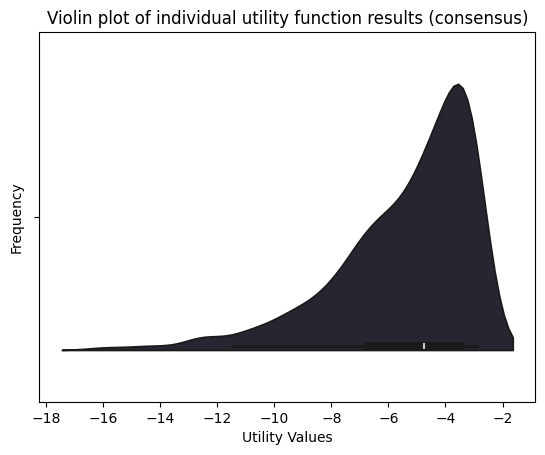

In [31]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_X_q3, 2000, x0, omega)

In [32]:
# Ahora tenemos que evaluar esta clusterización con alguna métrica.
perplexity_X_q3 = perplexity (agreements_X_q3, 2000)

Cluster Probabilities: [1.]
Entropy: 0.0
Perplexity: 1.0


# 2. Grupos por $\omega$

## 2.1. q1

In [24]:
# Importamos los datos:

file_path = "break_w_PVE_q1.pickle"

with open(file_path, 'rb') as f:
    agreements_w_q1 = pickle.load(f)

file_path = "graph_w_q1.pickle"

with open(file_path, 'rb') as f:
    graph_w_q1 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 108577, 114722, 118816, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 6205, 8259, 118851, 71754, 43084, 8270, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520, 6473, 119119

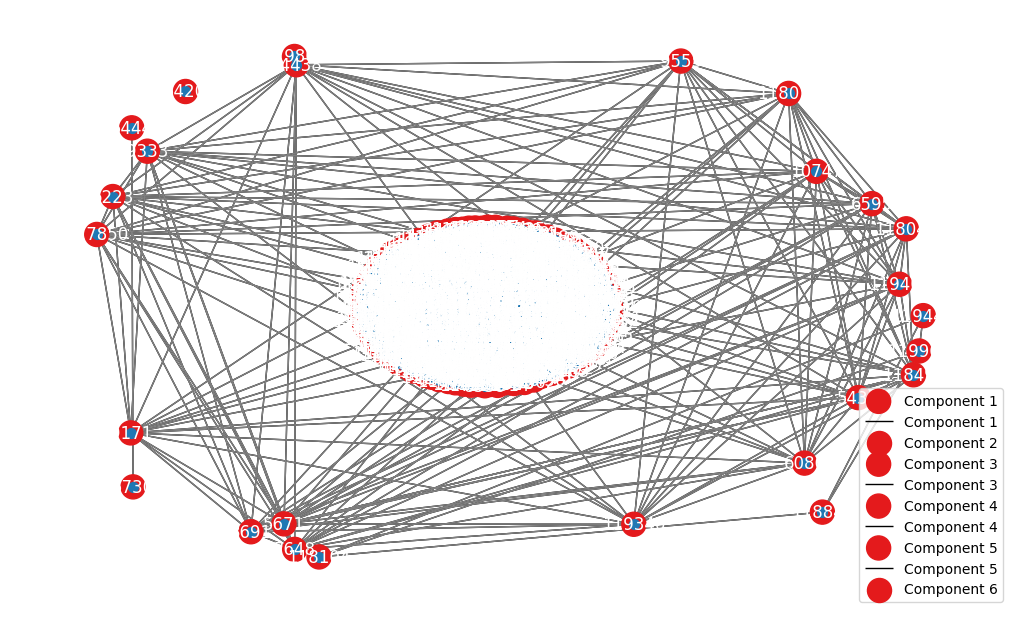

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5291,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5430,
  5432,
  5443,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5777,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5937,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6088,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,
  6354,
  6361,
  6365,
  6409,
  6410,
  6411,
  6446,


In [25]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_w_q1)

In [26]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q1[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_w_q1, 2000, omega, omega)

Group: 0
Maximum value: -7.050272883999121e-15
Coordinates of the maximum: [0.11111115 0.11111115 0.11111115 0.55555556 0.11111115]
Distance between the vectors: 0.0018019112430418193
Group: 1
Maximum value: -0.05534568689547581
Coordinates of the maximum: [0.15735614 0.19495889 0.22594898 0.24671394 0.26197607]
Distance between the vectors: 0.040059864663948015
Group: 2
Maximum value: -0.08046835793936705
Coordinates of the maximum: [0.09764964 0.48717958 0.09764964 0.09764964 0.32468703]
Distance between the vectors: 0.18257354390441025
Group: 3
Maximum value: -0.0459464217208657
Coordinates of the maximum: [0.34814059 0.14307401 0.10660556 0.29722288 0.17535697]
Distance between the vectors: 0.07455237418793768
Group: 4
Maximum value: -3.0709457128122784e-16
Coordinates of the maximum: [0.41666666 0.33333333 0.08333333 0.08333333 0.08333333]
Distance between the vectors: 0.023127658858442257
Group: 5
Maximum value: -7.049735956281151e-15
Coordinates of the maximum: [0.55555556 0.111

C:\Users\artur\AppData\Local\Temp\ipykernel_26096\3438105508.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Individual Utility', data=all_data, palette='pastel')


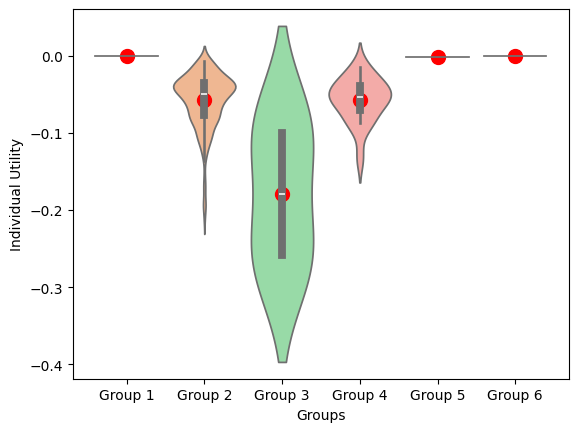

In [77]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_w_q1, 2000, omega, omega)

C:\Users\artur\AppData\Local\Temp\ipykernel_26096\2558034465.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Individual Utilities', data=all_data, palette='pastel')


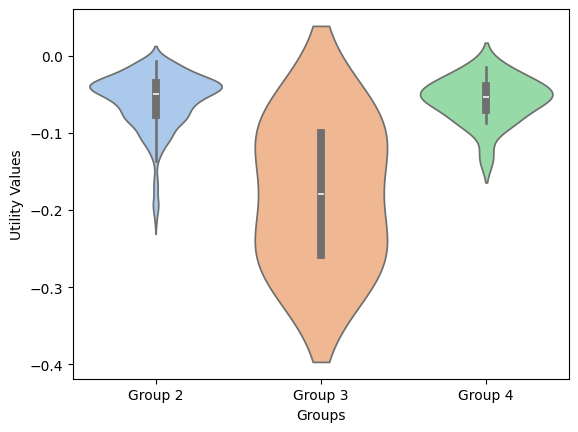

In [60]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_w_q1, 2000, omega, omega)

In [39]:
# Ahora tenemos que evaluar esta clusterización con alguna métrica.
perplexity_w_q1 = perplexity (agreements_w_q1, 2000)

Cluster Probabilities: [0.97031963 0.00114155 0.02054795 0.00228311 0.00456621 0.00114155]
Entropy: 0.23519821668191984
Perplexity: 1.177068447468152


# 2.2. q2

In [36]:
# Importamos los datos:

file_path = "break_w_PVE_q2.pickle"

with open(file_path, 'rb') as f:
    agreements_w_q2 = pickle.load(f)

file_path = "graph_w_q2.pickle"

with open(file_path, 'rb') as f:
    graph_w_q2 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 108577, 114722, 118816, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 118842, 6205, 8259, 118851, 71754, 43084, 8270, 6223, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520

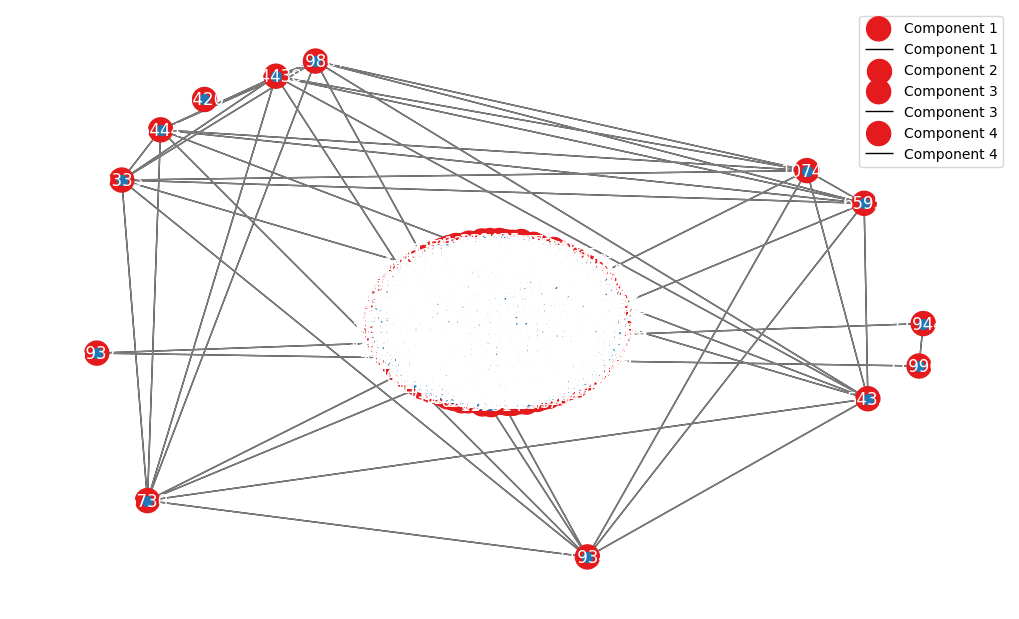

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5291,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5430,
  5432,
  5443,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5671,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5777,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6086,
  6088,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6223,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,
  6354,
  6361,
  6365,
  6409,
  6410,


In [11]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_w_q2)

In [37]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q2[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_w_q2, 2000, omega, omega)

Group: 0
Maximum value: -7.050272883999121e-15
Coordinates of the maximum: [0.11111115 0.11111115 0.11111115 0.55555556 0.11111115]
Distance between the vectors: 0.005090515380293268
Group: 1
Maximum value: -0.05658071716219491
Coordinates of the maximum: [0.16074046 0.19467423 0.2242201  0.24754546 0.26165783]
Distance between the vectors: 0.040650137863201145
Group: 2
Maximum value: -0.05127762943571862
Coordinates of the maximum: [0.10457751 0.51792512 0.23581082 0.10457751 0.10457751]
Distance between the vectors: 0.10971887904479942
Group: 3
Maximum value: -0.07115410479064693
Coordinates of the maximum: [0.42808846 0.18227983 0.09979485 0.23283025 0.16152818]
Distance between the vectors: 0.07038086100994063


C:\Users\artur\AppData\Local\Temp\ipykernel_26096\3165858195.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Individual Utilities', data=all_data, palette='pastel')


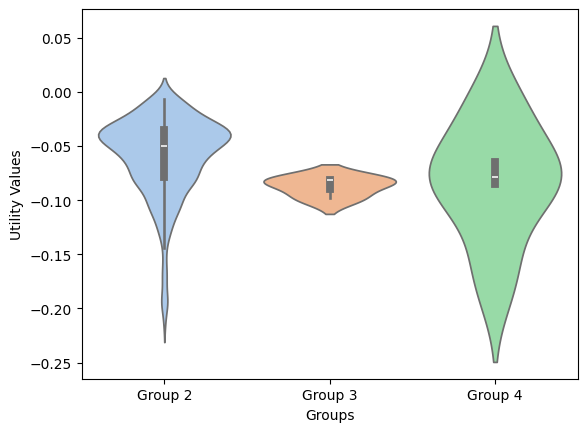

In [38]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_w_q2, 2000, omega, omega)

## AHORA, PARA CADA GRUPO OBTENIDO CON ESTE Q, OBTENEMOS EL CONSENSO PARA SUS MATRICES DE DECISIÓN, Y LUEGO OBTENEMOS EL RANKING

In [39]:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q2[:,2000-1,:])), axis=0)
len(final_matrices)

4

In [40]:
final_matrices

array([[0.112, 0.113, 0.111, 0.551, 0.112],
       [0.146, 0.174, 0.205, 0.233, 0.241],
       [0.156, 0.436, 0.185, 0.114, 0.108],
       [0.375, 0.178, 0.112, 0.193, 0.142]])

In [15]:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q2[:,2000-1,:])),axis=0)

indices_grupos = []
aprox_execution = replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q2[:,2000-1,:]))
for matrix in final_matrices:
    indices_grupo = []
    i=0
    for exec in aprox_execution:
        if np.array_equal(exec, matrix):
            indices_grupo += [i]
        i+=1
    indices_grupos += [indices_grupo]
omega_grupos = []
x0_grupos = []
names_grupos = []

for index in indices_grupos:
  omega_grupos += [get_subarray_from_indices(np.unique(index),omega)]
  x0_grupos += [get_subarray_from_indices (np.unique(index),x0)]
  names_grupos += [get_subarray_from_indices (np.unique(index),names)]

### Grupo del Agente Solo

In [42]:
x0_grupos[0]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0], dtype=int64)]

### Grupon 1

863


C:\Users\artur\AppData\Local\Temp\ipykernel_26096\2788890923.py:99: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.violinplot(x='utility_value', data=df, color="blue",


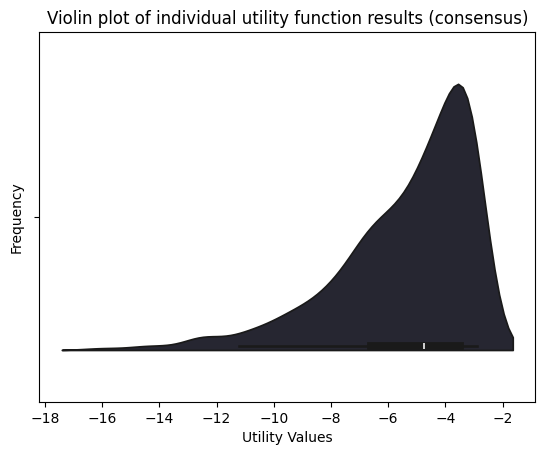

In [23]:
utilidad_individual_grupo (grupo1_w, 1000, np.array(x0_grupos[1]), np.array(omega_grupos[1]))

Execution time: 2.0547304153442383 seconds


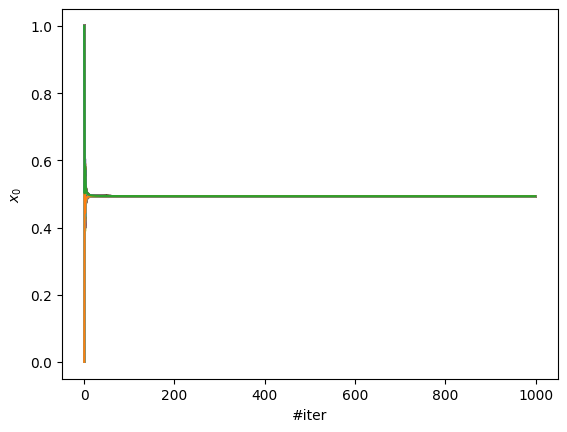

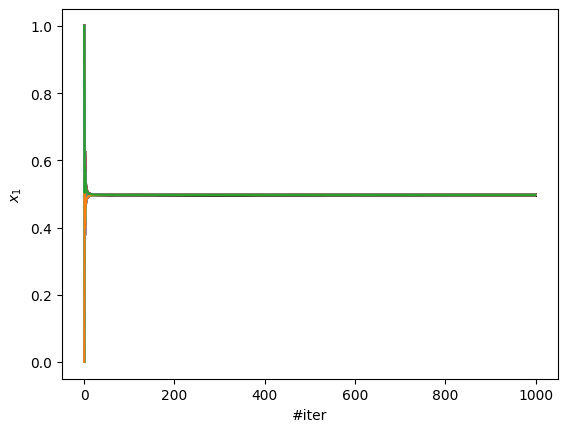

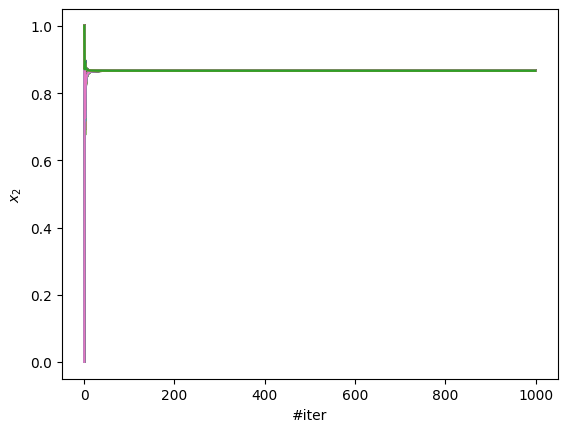

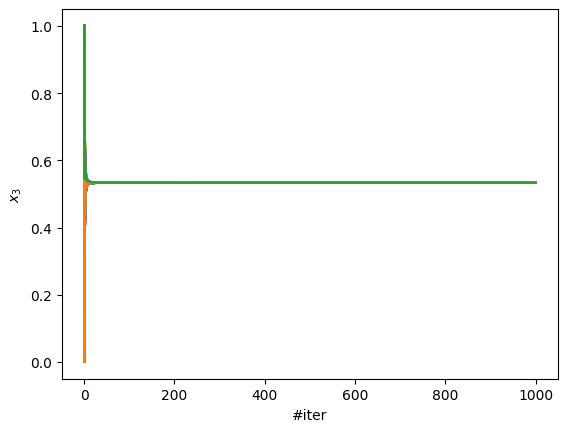

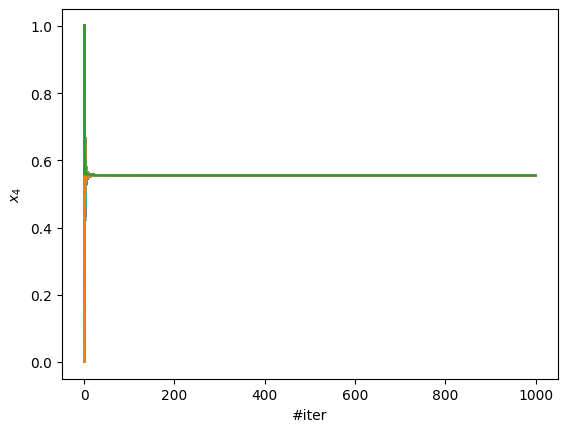

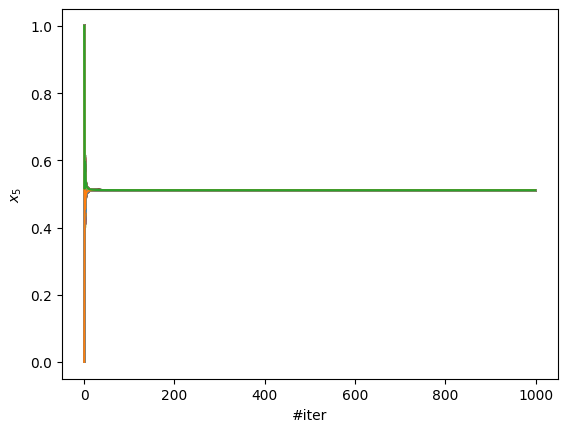

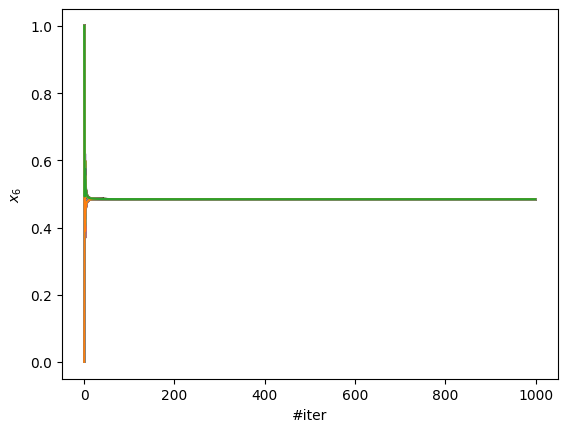

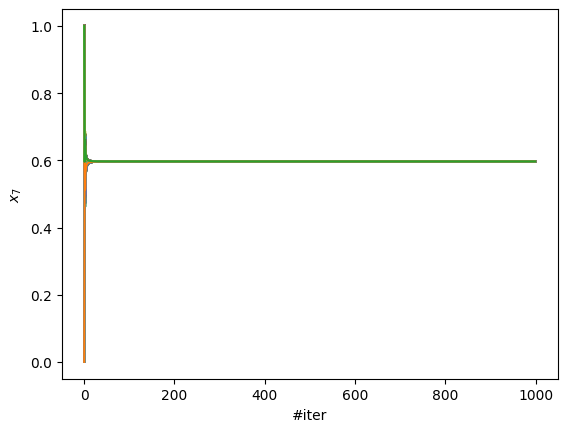

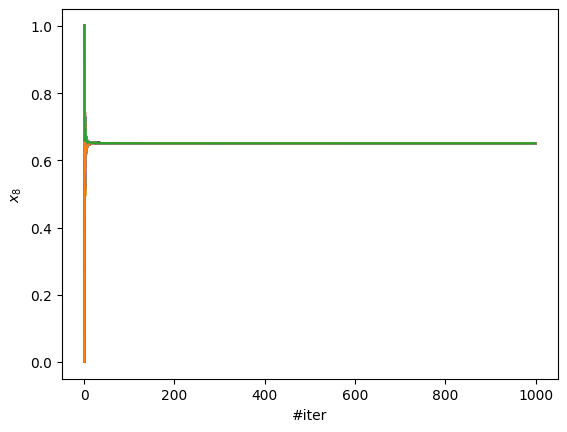

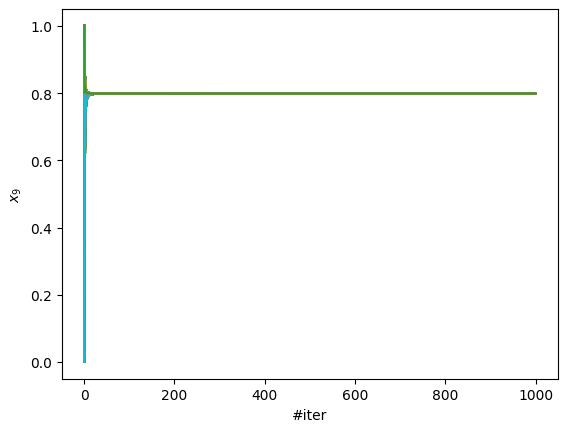

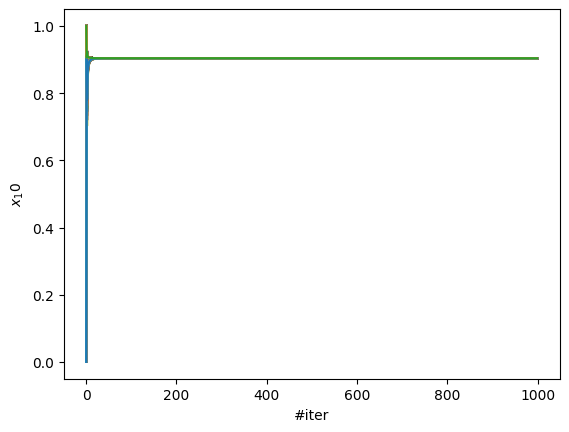

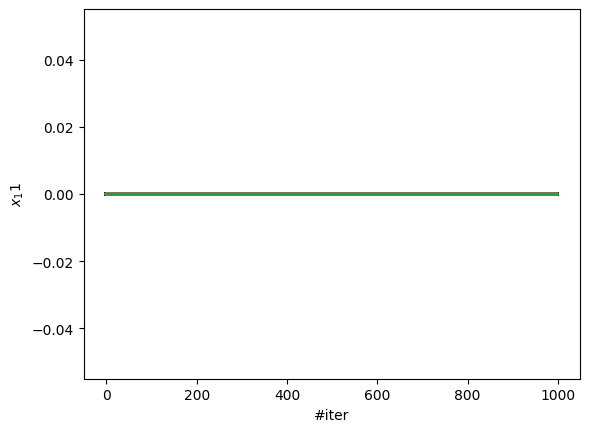

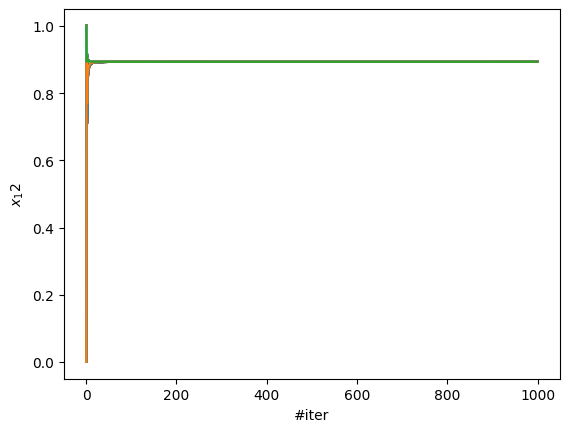

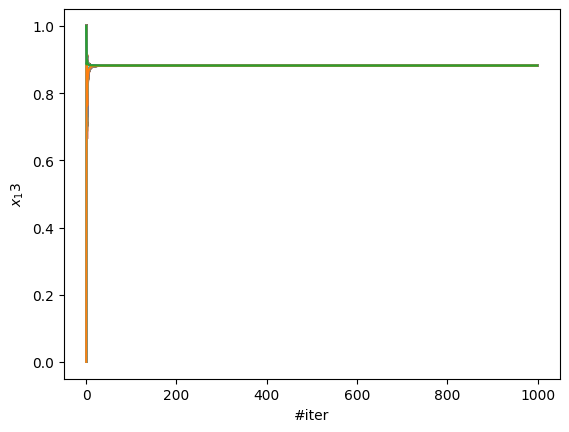

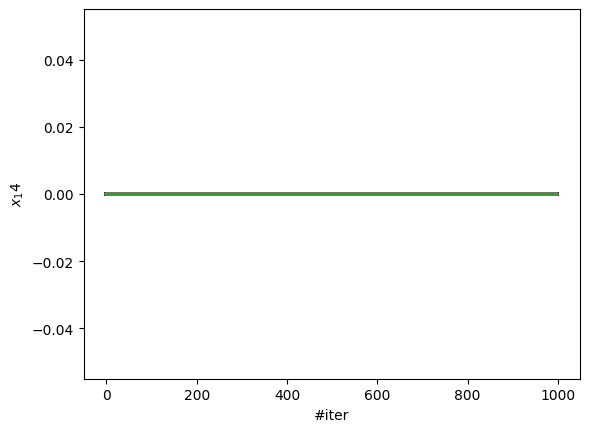

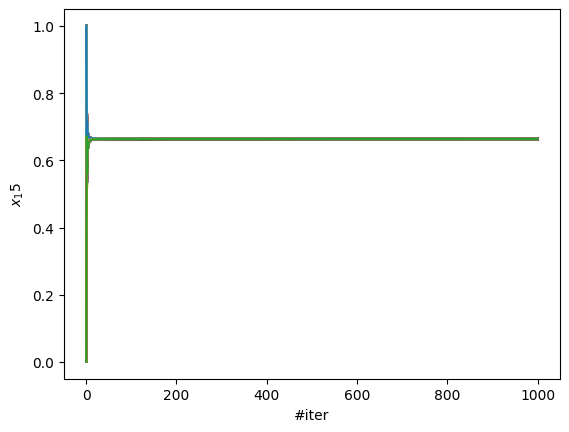

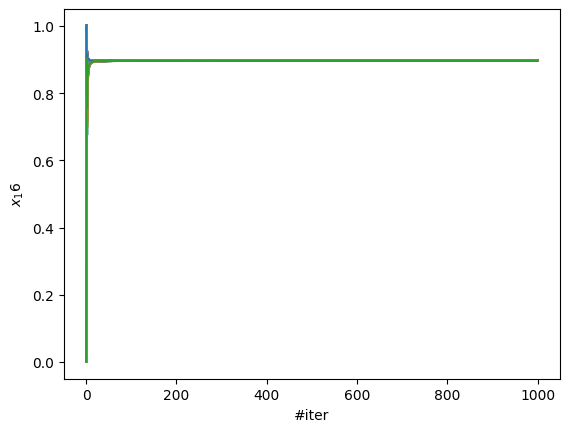

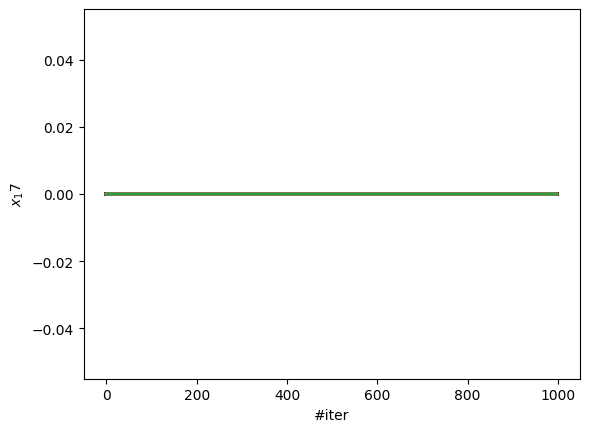

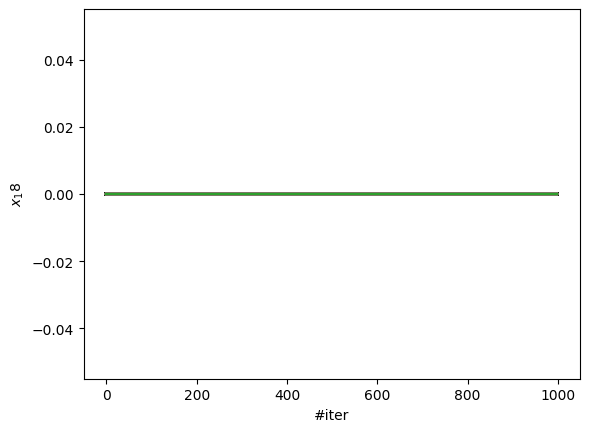

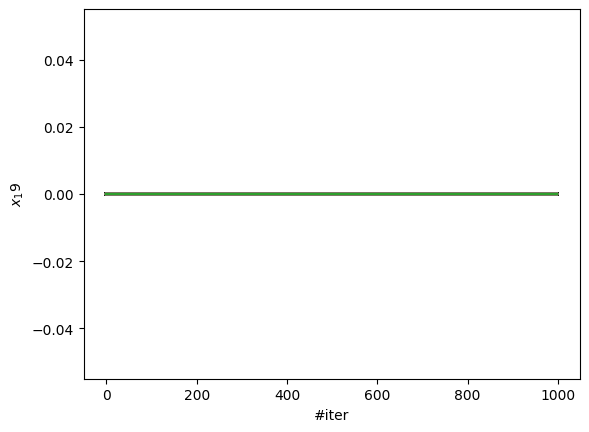

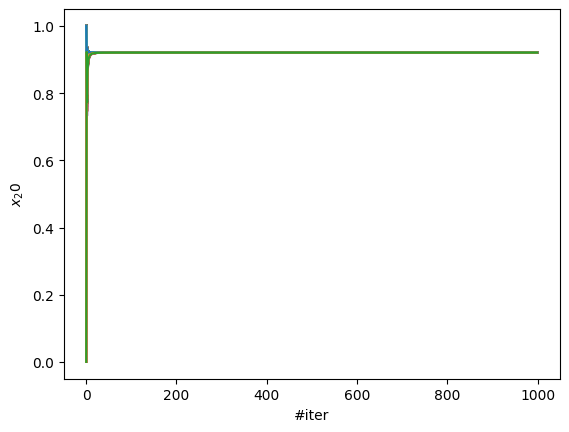

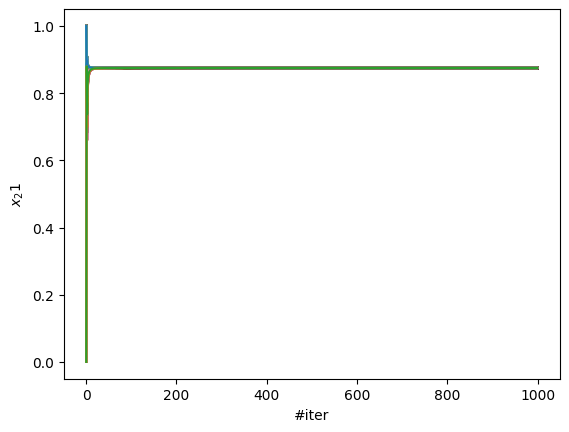

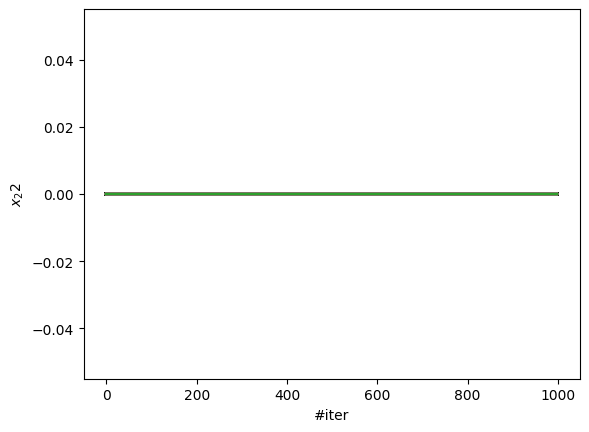

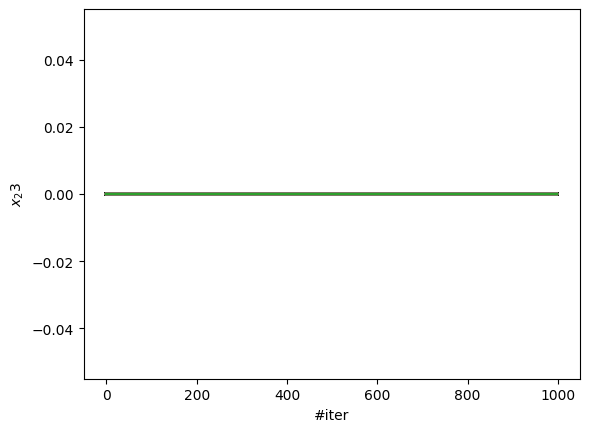

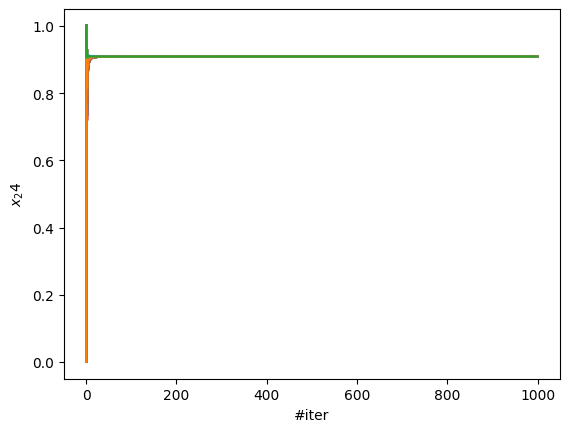

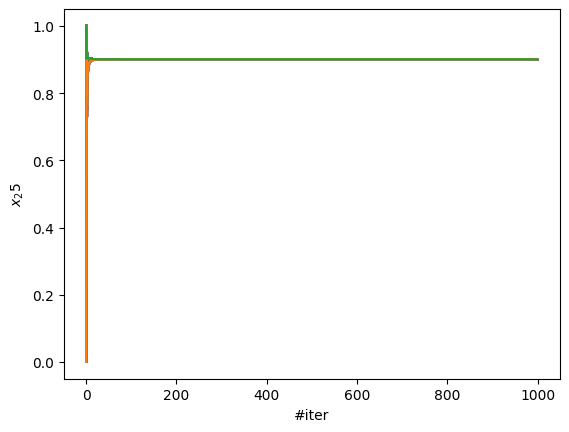

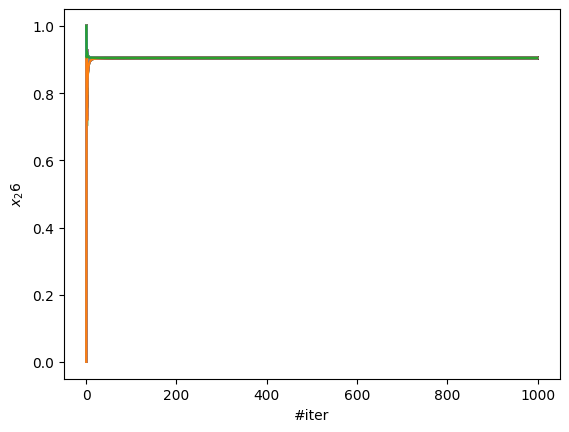

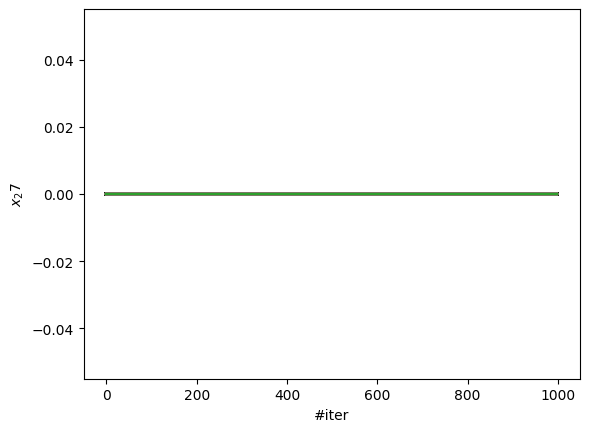

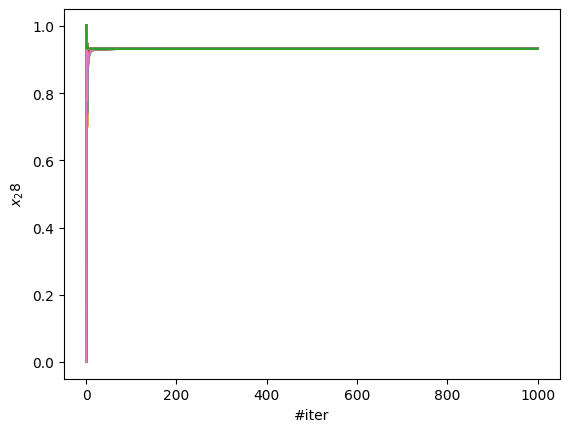

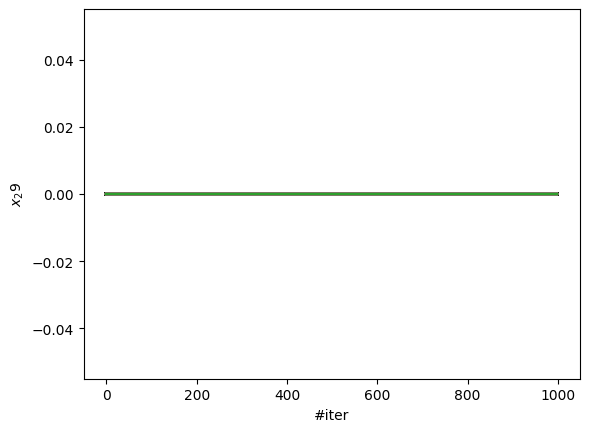

Execution time: 2072.737551689148 seconds


In [16]:
n = len(x0_grupos[1])
mindist = np.repeat(1000,n)
start_time = time.time()
G = generate_network_nx_eficient(names_grupos[1], np.array(x0_grupos[1]), mindist)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

num_iter = 1000

start_time = time.time()

grupo1_w, D = matmul_DGD_PROJ_MINALPHA_MINEPS_INIT_decision_matrix(False, np.repeat(300,n), names_grupos[1], G, np.array(omega_grupos[1]), np.array(x0_grupos[1]), num_iter,1)
plot_consensus(grupo1_w)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [44]:
grupo1_w[:,999,:][0]

array([0.49336911, 0.49684656, 0.86632329, 0.53288229, 0.55528492,
       0.51112046, 0.48434725, 0.59664354, 0.65091118, 0.79879313,
       0.90385809, 0.        , 0.8930779 , 0.88197178, 0.        ,
       0.66346219, 0.89585285, 0.        , 0.        , 0.        ,
       0.92067594, 0.87477805, 0.        , 0.        , 0.90891426,
       0.90098818, 0.90452872, 0.        , 0.93160483, 0.        ])

### Grupo 2

Execution time: 0.0249786376953125 seconds


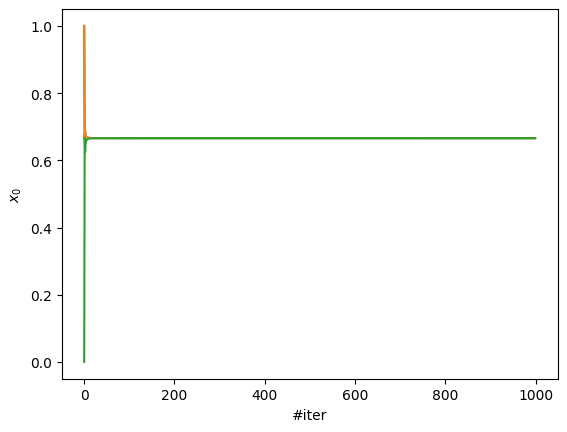

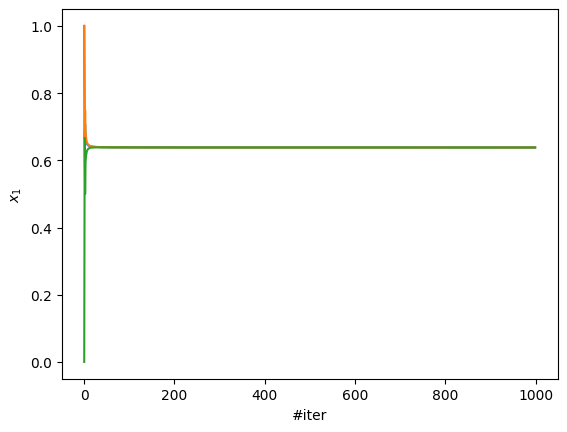

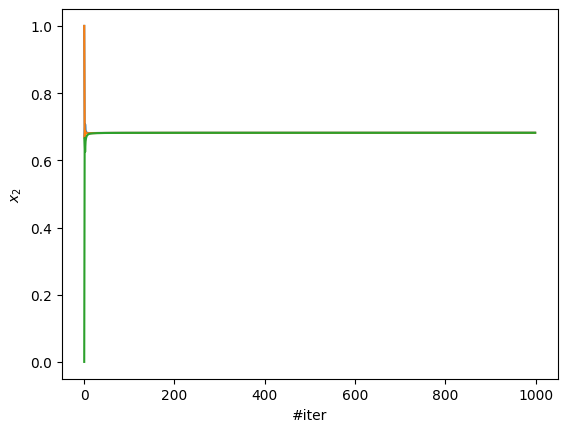

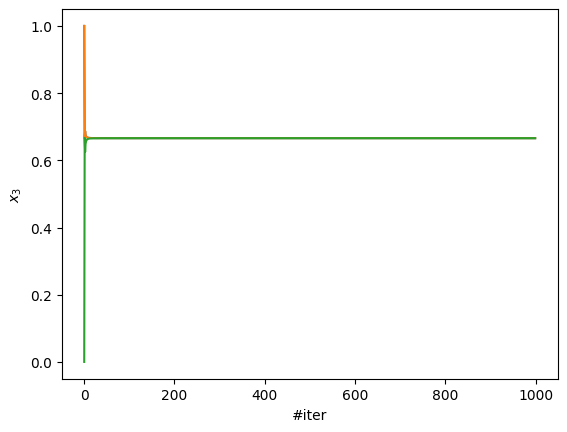

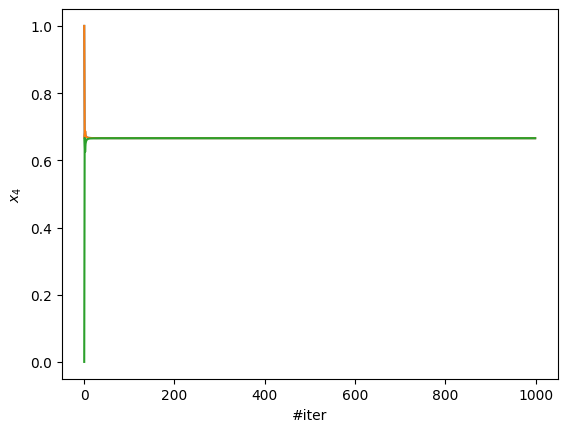

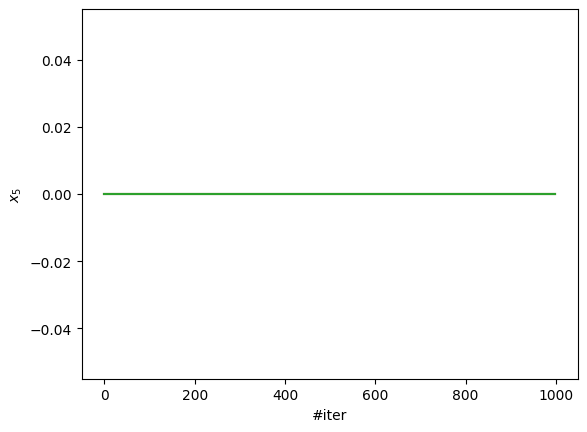

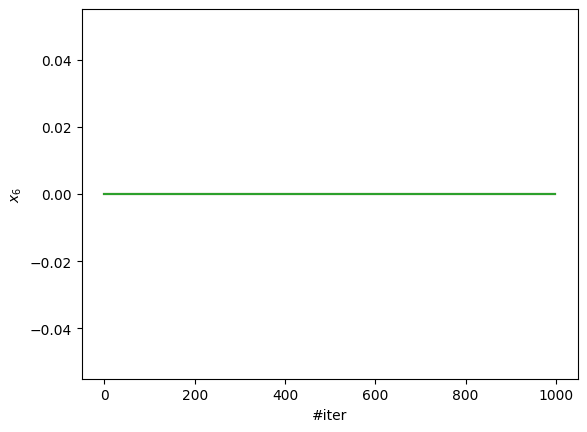

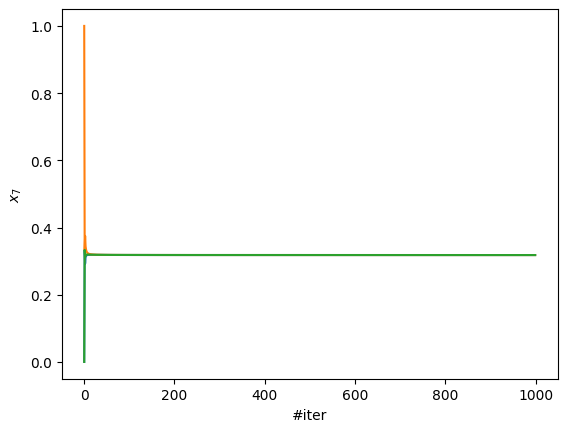

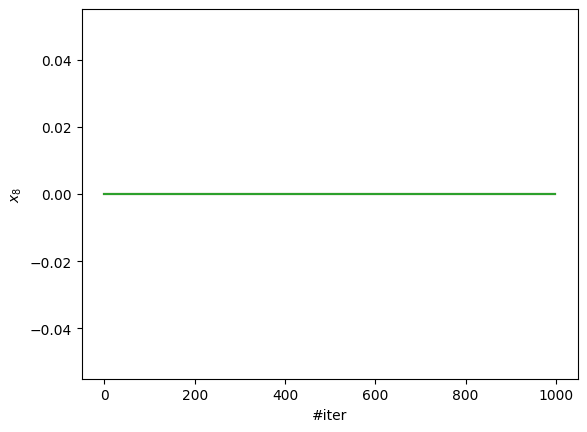

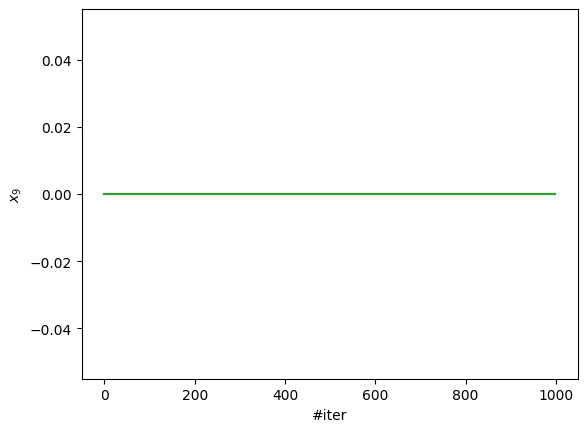

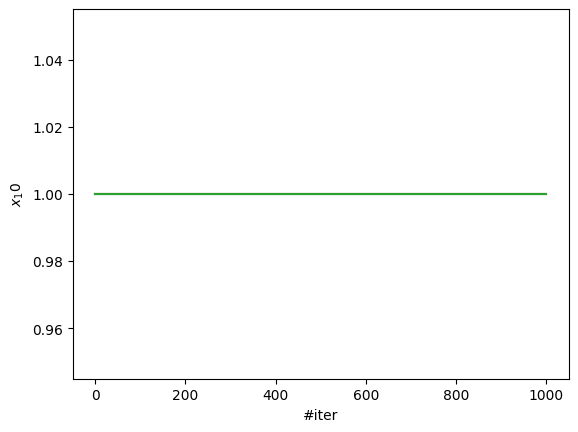

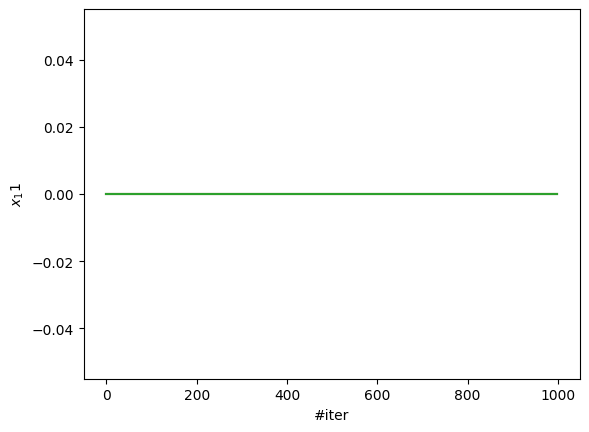

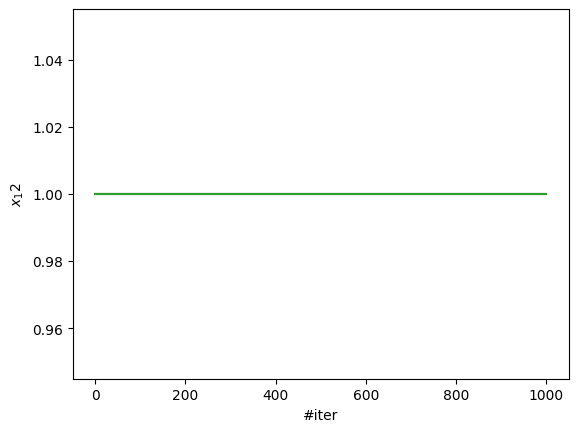

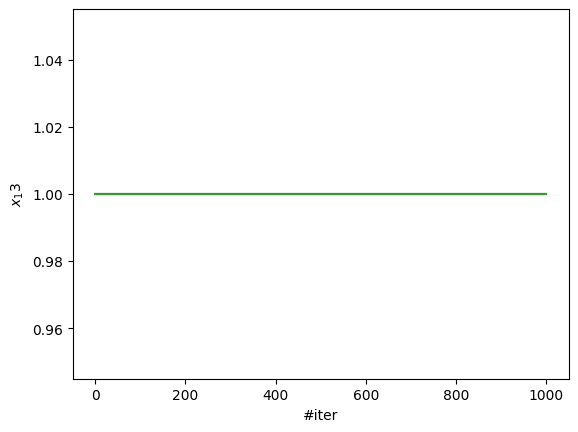

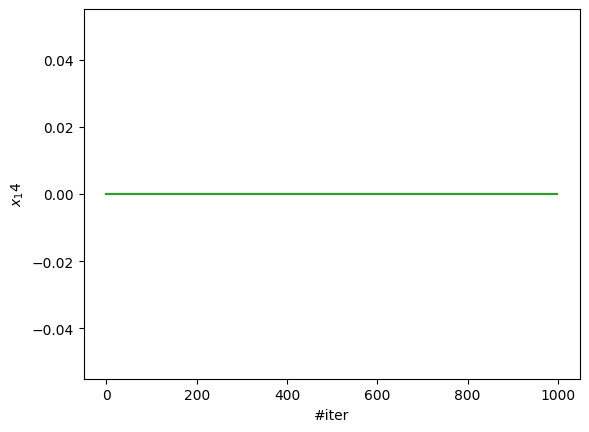

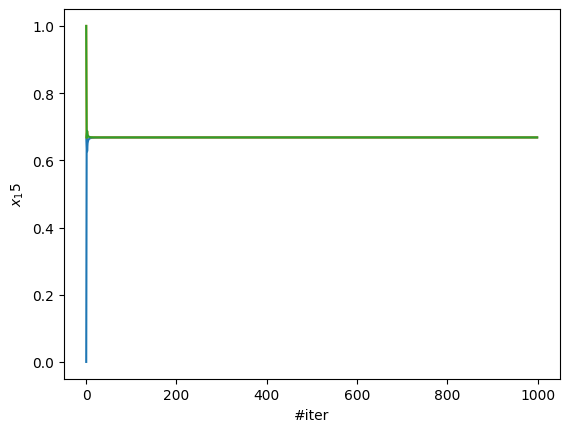

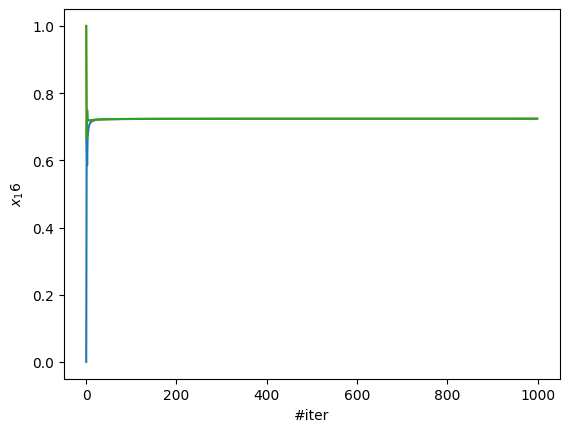

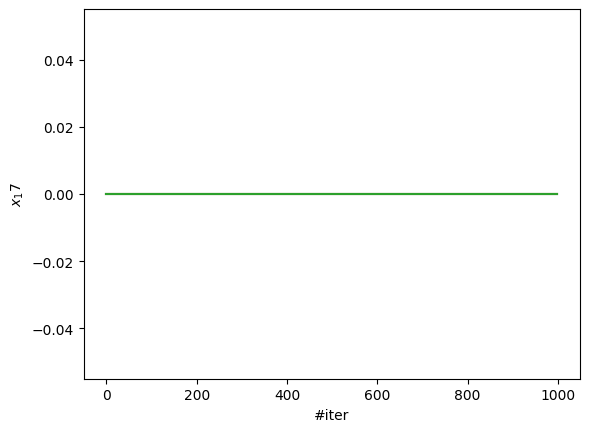

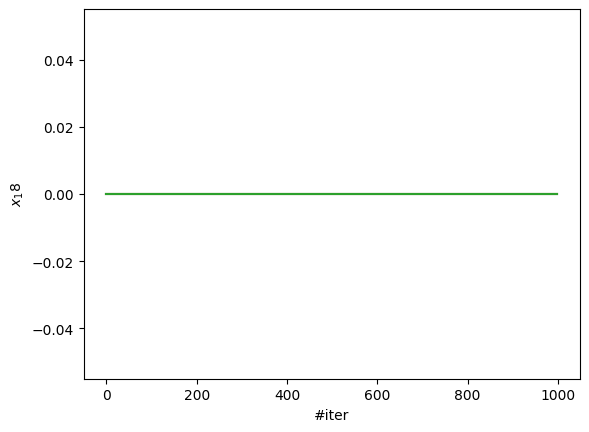

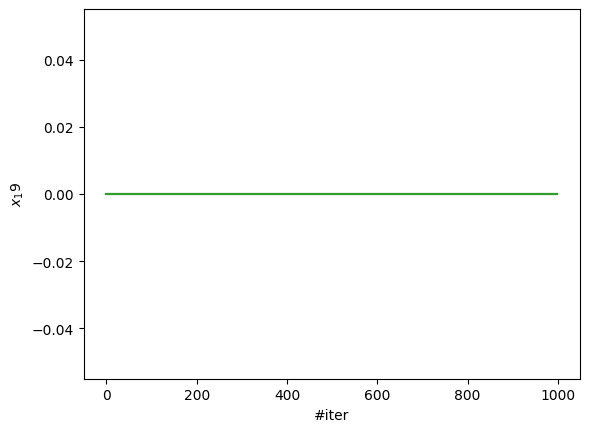

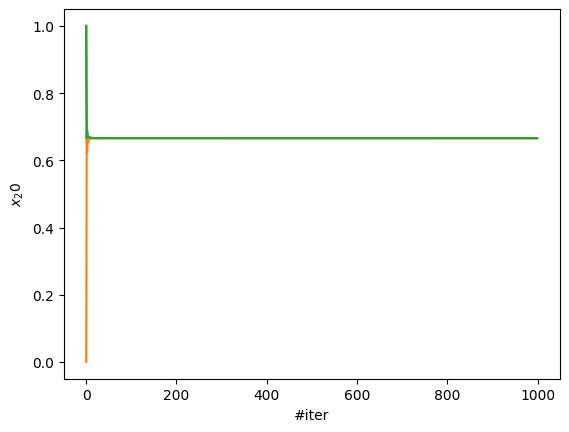

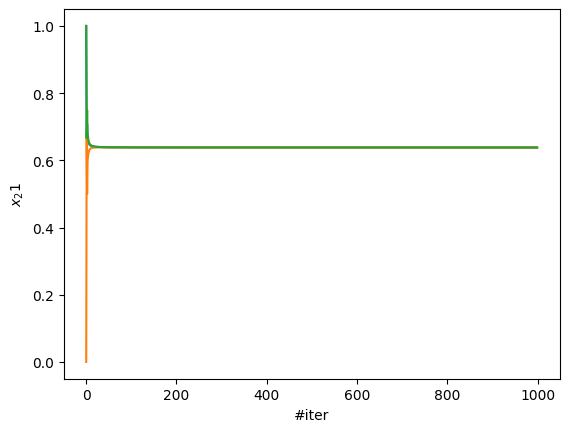

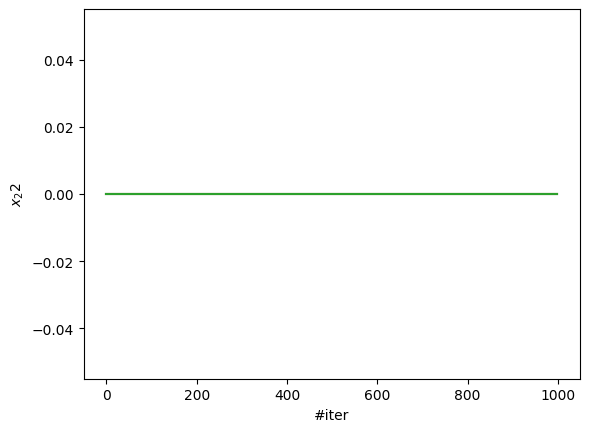

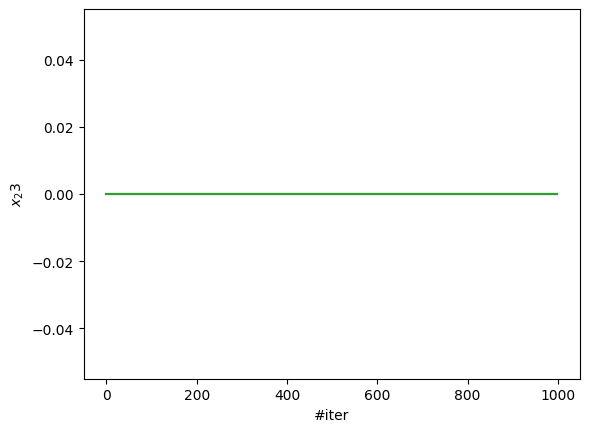

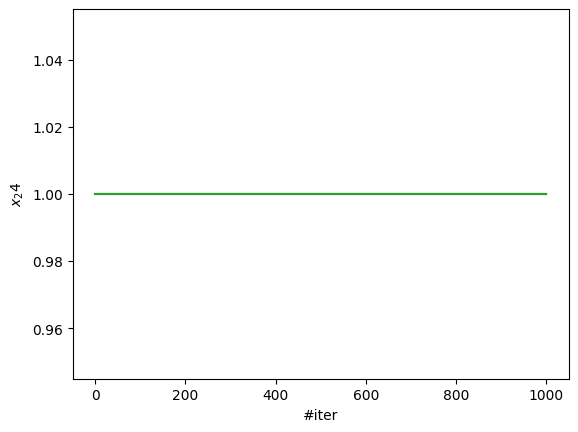

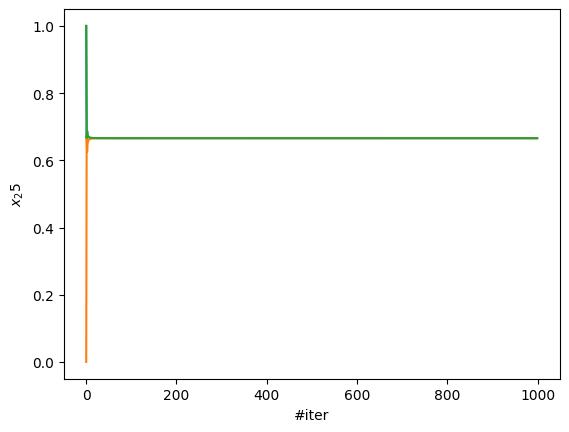

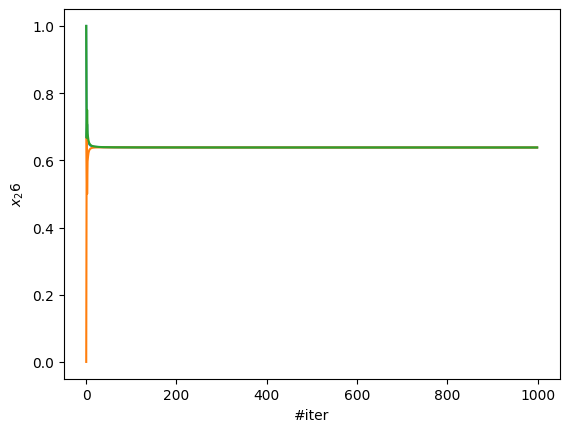

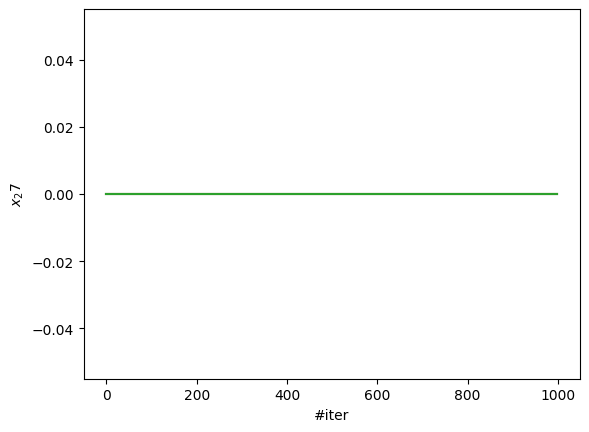

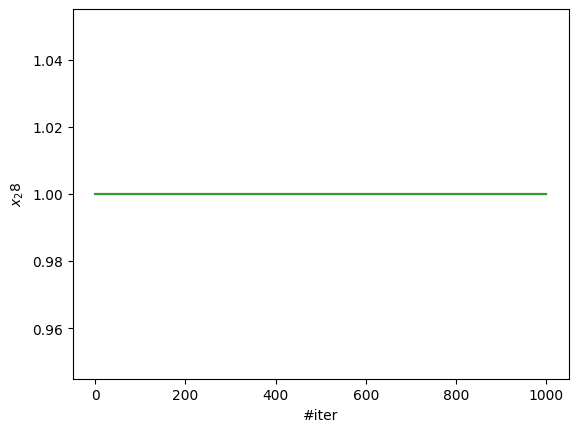

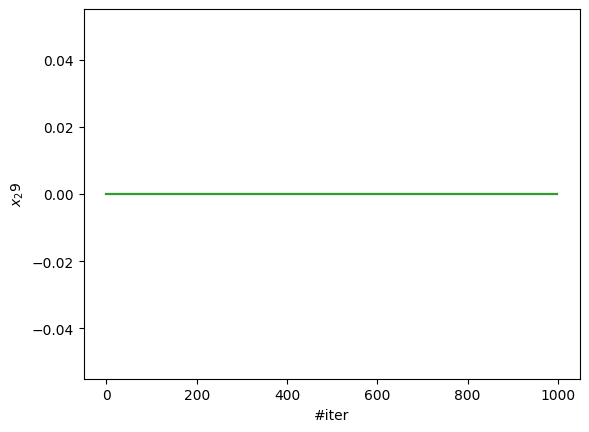

Execution time: 10.401500463485718 seconds


In [17]:
n = len(x0_grupos[2])
mindist = np.repeat(1000,n)
start_time = time.time()
G = generate_network_nx_eficient(names_grupos[2], np.array(x0_grupos[2]), mindist)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

num_iter = 1000

start_time = time.time()

grupo2_w, D = matmul_DGD_PROJ_MINALPHA_MINEPS_INIT_decision_matrix(False, np.repeat(300,n), names_grupos[2], G, np.array(omega_grupos[2]), np.array(x0_grupos[2]), num_iter,1)
plot_consensus(grupo2_w)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [45]:
grupo2_w[:,999,:][0]

array([0.66594287, 0.63815451, 0.68191656, 0.66594241, 0.66594204,
       0.        , 0.        , 0.31808034, 0.        , 0.        ,
       1.        , 0.        , 1.        , 1.        , 0.        ,
       0.66812295, 0.7236984 , 0.        , 0.        , 0.        ,
       0.66594231, 0.63815453, 0.        , 0.        , 1.        ,
       0.66594244, 0.63815437, 0.        , 1.        , 0.        ])

### Grupo 3

Execution time: 0.0 seconds


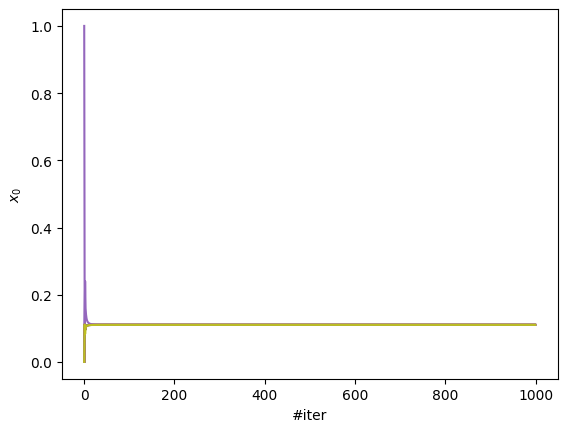

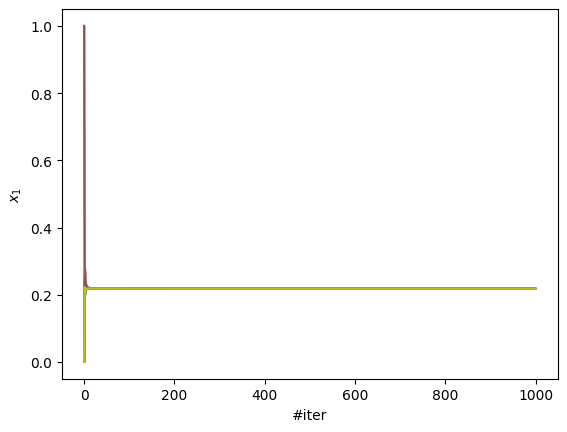

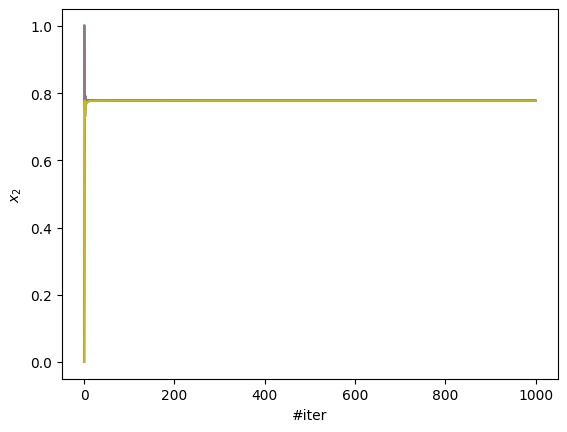

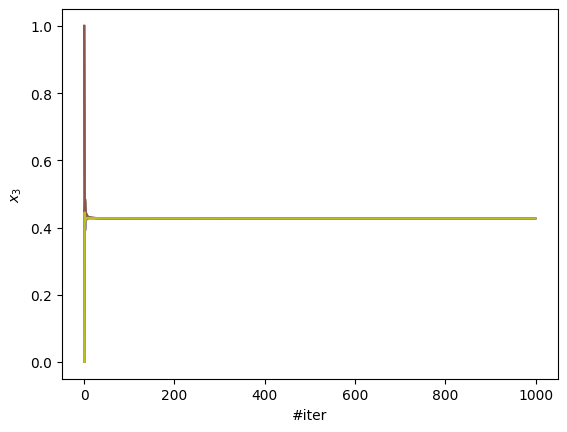

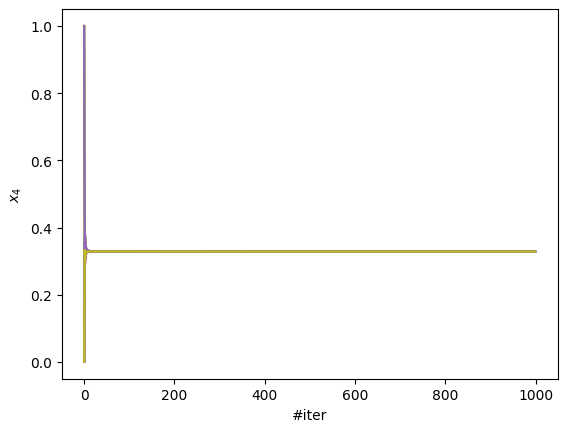

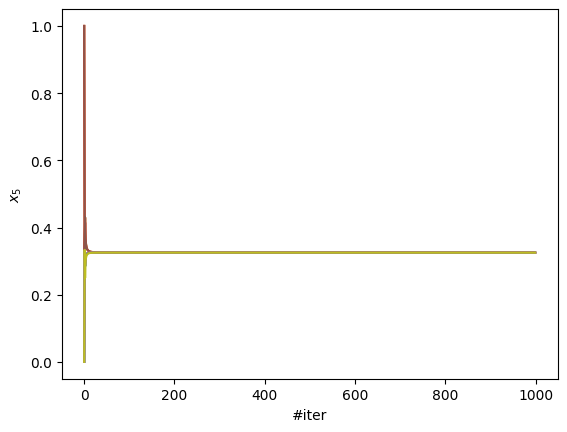

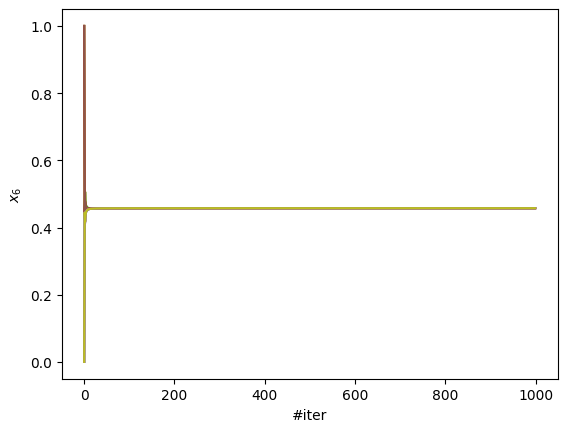

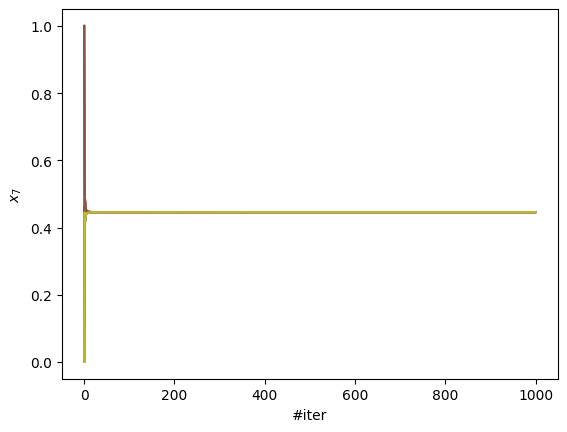

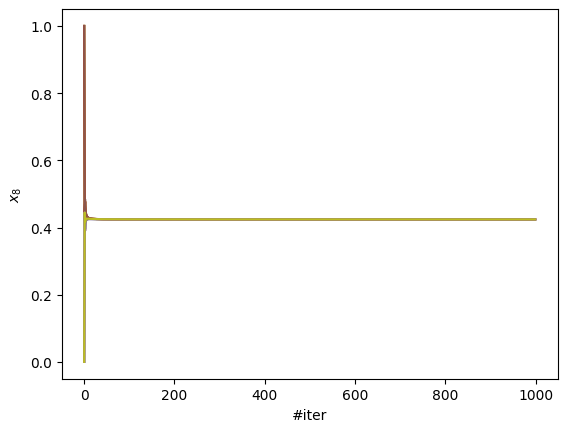

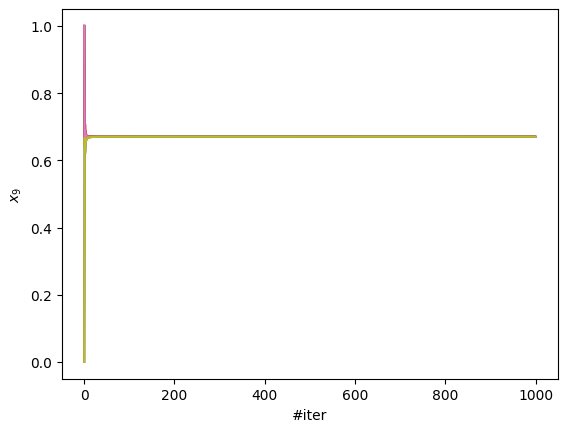

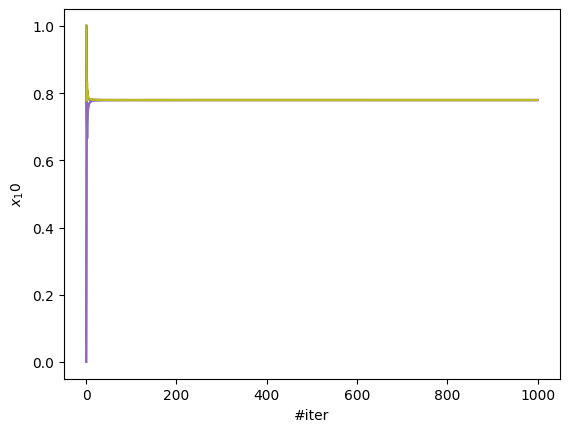

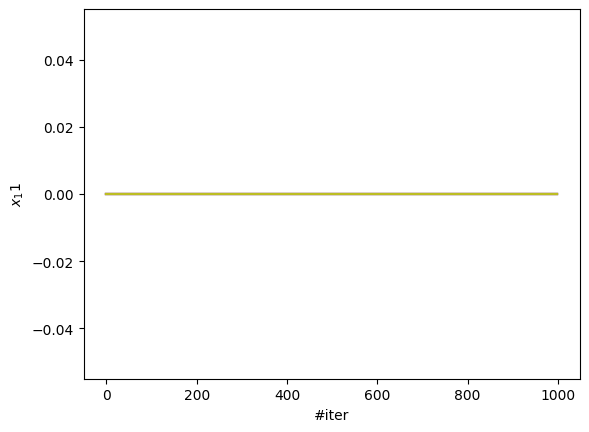

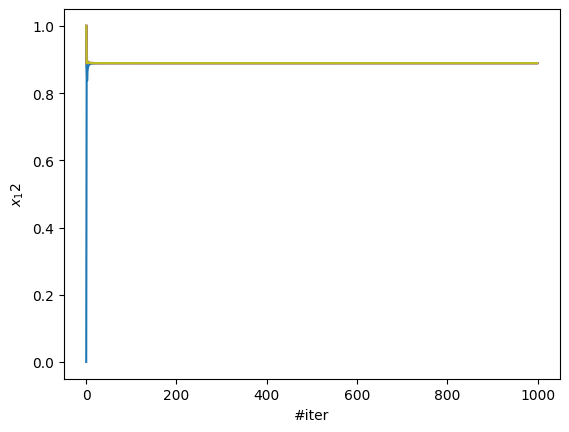

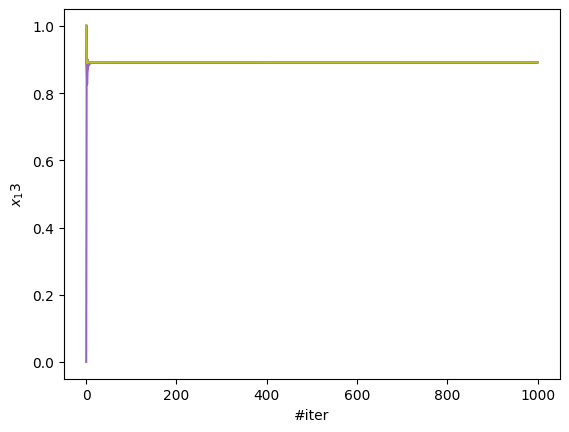

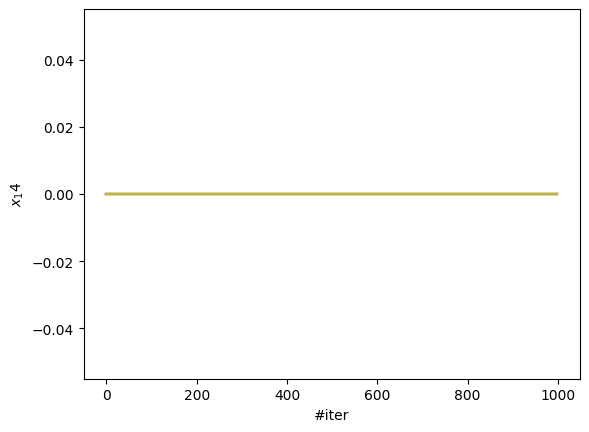

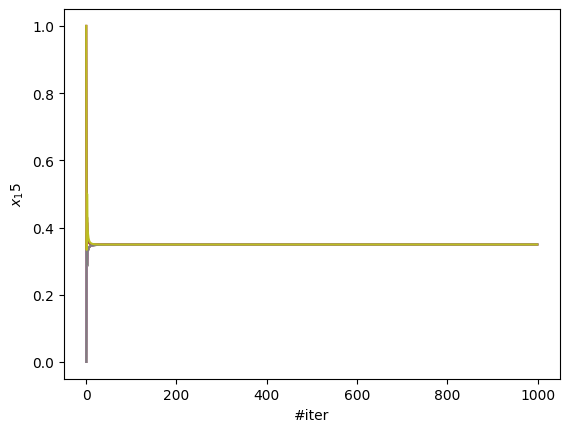

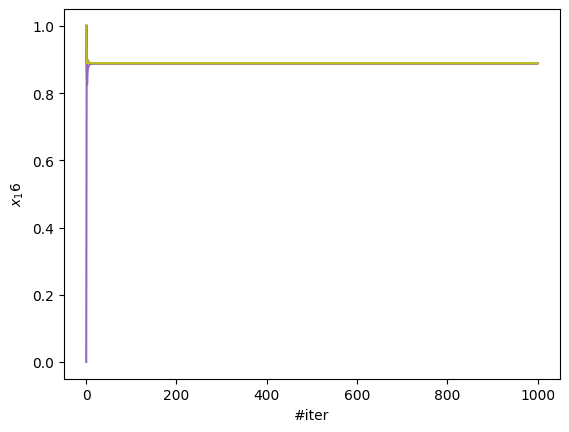

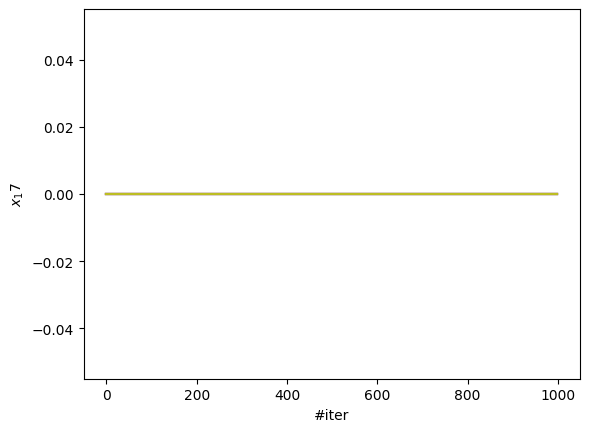

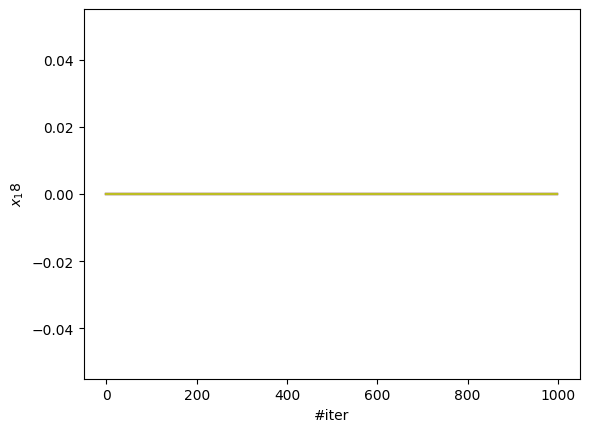

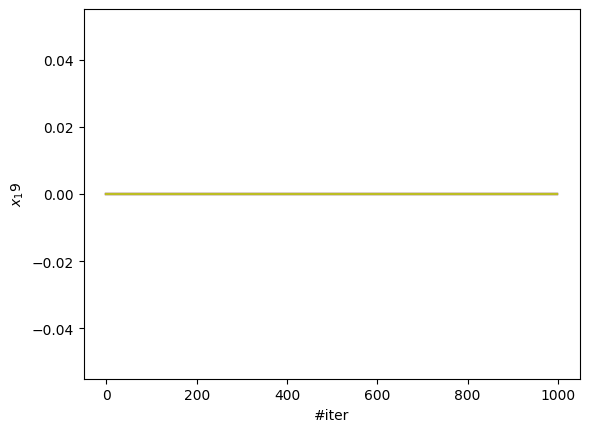

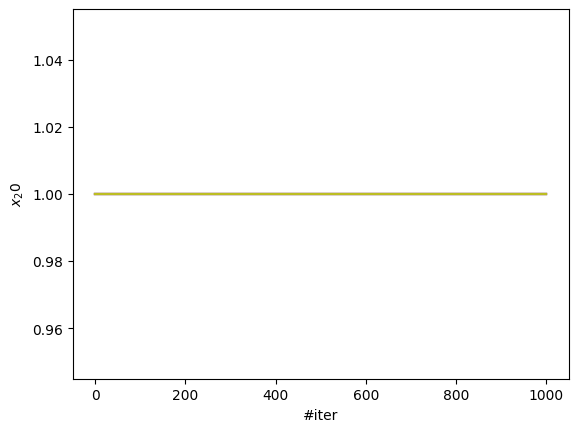

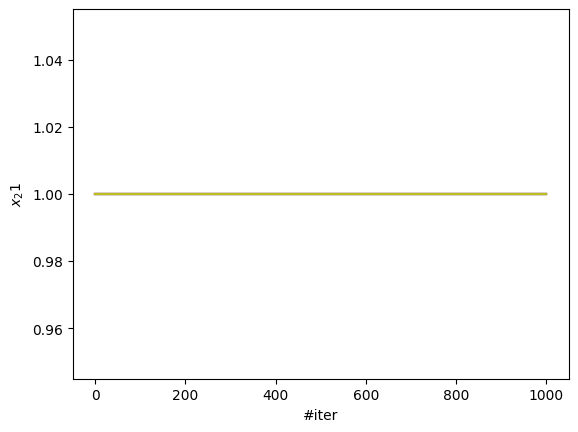

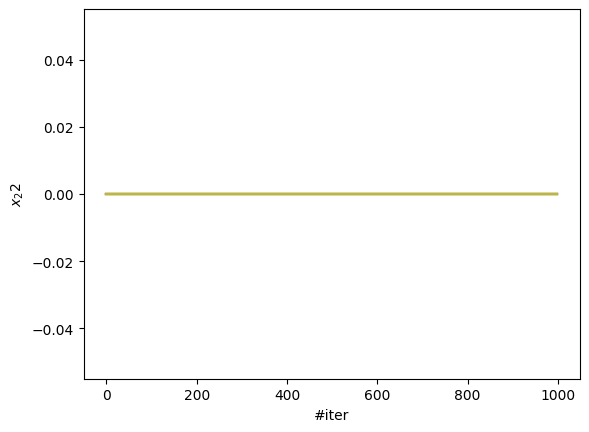

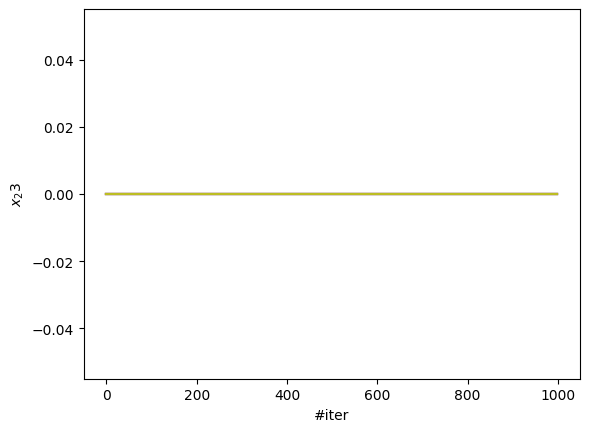

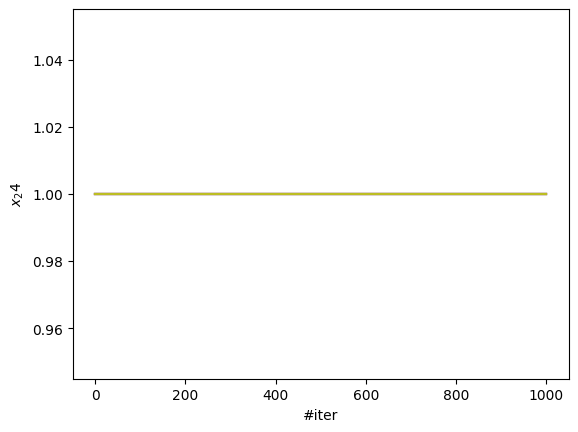

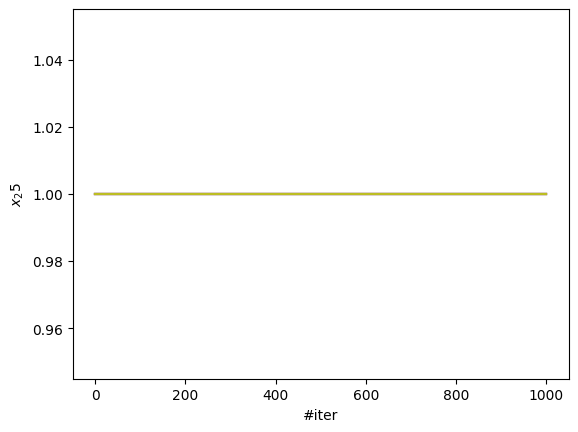

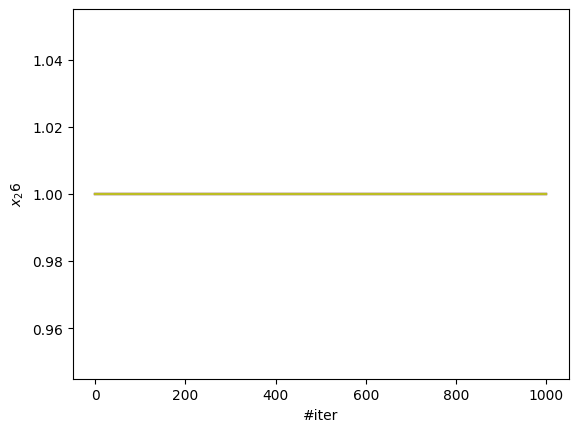

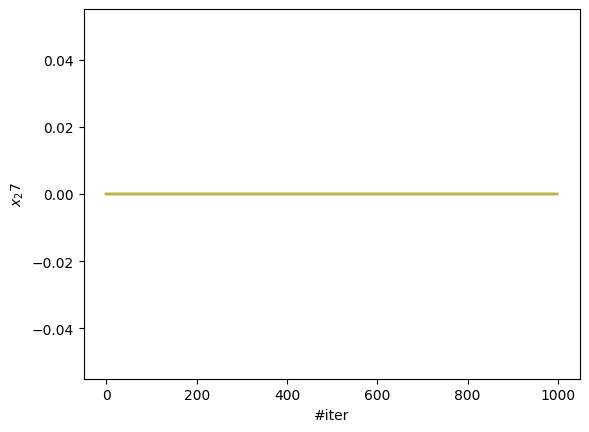

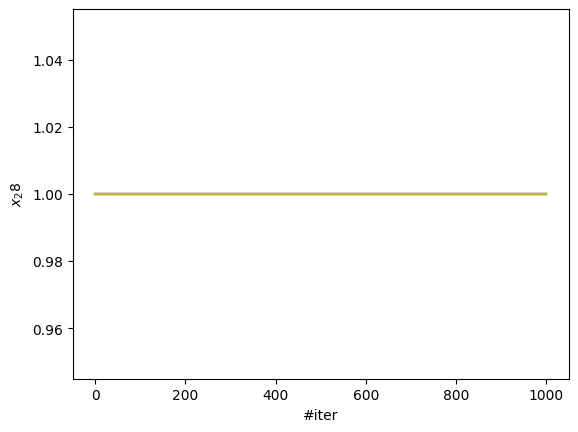

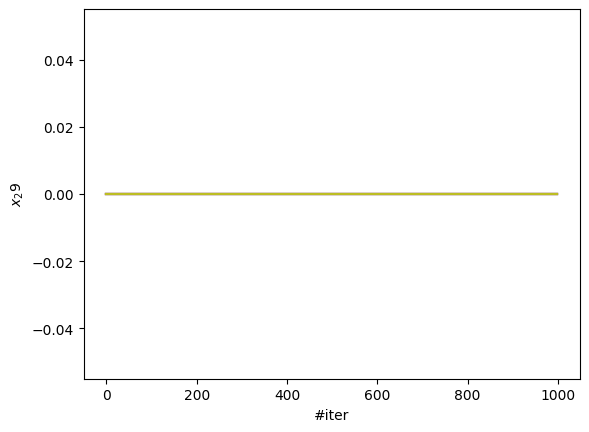

Execution time: 25.07305121421814 seconds


In [18]:
n = len(x0_grupos[3])
mindist = np.repeat(1000,n)
start_time = time.time()
G = generate_network_nx_eficient(names_grupos[3], np.array(x0_grupos[3]), mindist)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

num_iter = 1000

start_time = time.time()

grupo3_w, D = matmul_DGD_PROJ_MINALPHA_MINEPS_INIT_decision_matrix(False, np.repeat(300,n), names_grupos[3], G, np.array(omega_grupos[3]), np.array(x0_grupos[3]), num_iter,1)

plot_consensus(grupo3_w)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [46]:
grupo3_w[:,999,:][0]

array([0.11025228, 0.21830797, 0.77764936, 0.42704721, 0.32844672,
       0.32523379, 0.45756615, 0.44572569, 0.4240948 , 0.67031017,
       0.77948626, 0.        , 0.88944873, 0.89163354, 0.        ,
       0.34951771, 0.88922872, 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ])

### Ahora aplicamos TOPSIS a cada grupo para obtener el ranking

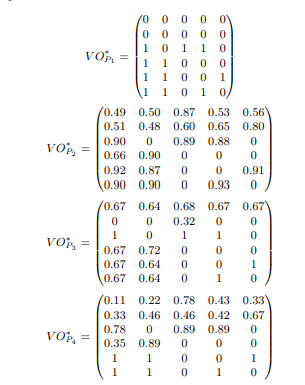

In [55]:
# uwTOP.

# from uwTOPSIS.uwTOPSIS import *

VO_P1 = pd.DataFrame({
    "c1": [0, 0, 1, 1, 1, 1],
    "c2": [0, 0, 0, 1, 1, 1],
    "c3": [0, 0, 1, 0, 0, 0],
    "c4": [0, 0, 1, 0, 0, 1],
    "c5": [0, 0, 0, 0, 1, 0]
})

VO_P2 = pd.DataFrame({
    "c1": [0.49, 0.51, 0.90, 0.66, 0.92, 0.90],
    "c2": [0.50, 0.48, 0.00, 0.90, 0.87, 0.90],
    "c3": [0.87, 0.60, 0.89, 0.00, 0.00, 0.00],
    "c4": [0.53, 0.65, 0.88, 0.00, 0.00, 0.93],
    "c5": [0.56, 0.80, 0.00, 0.00, 0.91, 0.00]
})

VO_P3 = pd.DataFrame({
    "c1": [0.67, 0.00, 1.00, 0.67, 0.67, 0.67],
    "c2": [0.64, 0.00, 0.00, 0.72, 0.64, 0.64],
    "c3": [0.68, 0.32, 1.00, 0.00, 0.00, 0.00],
    "c4": [0.67, 0.00, 1.00, 0.00, 0.00, 1.00],
    "c5": [0.67, 0.00, 0.00, 0.00, 1.00, 0.00]
})

VO_P4 = pd.DataFrame({
    "c1": [0.11, 0.33, 0.78, 0.35, 1.00, 1.00],
    "c2": [0.22, 0.46, 0.00, 0.89, 1.00, 1.00],
    "c3": [0.78, 0.46, 0.89, 0.00, 0.00, 0.00],
    "c4": [0.43, 0.42, 0.89, 0.00, 0.00, 1.00],
    "c5": [0.33, 0.67, 0.00, 0.00, 1.00, 0.00]
})

directions = ["max", "max", "max", "max", "max"]

weights_1 =  np.array([0.112, 0.113, 0.111, 0.551, 0.112])

weights_2 = np.array([0.146, 0.174, 0.205, 0.233, 0.241])

weights_3 = np.array([0.156, 0.436, 0.185, 0.114, 0.108])

weights_4 = np.array([0.375, 0.178, 0.112, 0.193, 0.142])

norm = "euclidean"
p = 2

print(TOPSIS(VO_P1, directions, weights_1, norm, p))
print(TOPSIS(VO_P2, directions, weights_2, norm, p))
print(TOPSIS(VO_P3, directions, weights_3, norm, p))
print(TOPSIS(VO_P4, directions, weights_4, norm, p))


[0.         0.         0.75934063 0.16981946 0.25845168 0.71673585]
[0.64877406 0.70789523 0.50276863 0.26872573 0.49553224 0.44972206]
[0.77669131 0.13719611 0.42731353 0.56353889 0.58339687 0.56620832]
[0.29376252 0.40044839 0.56003664 0.30514791 0.61986385 0.65143223]


## 2.3. q3

In [30]:
# Importamos los datos:

file_path = "break_w_PVE_q3.pickle"

with open(file_path, 'rb') as f:
    agreements_w_q3 = pickle.load(f)

file_path = "graph_w_q3.pickle"

with open(file_path, 'rb') as f:
    graph_w_q3 = pickle.load(f)

Component 1 nodes: {118785, 8194, 8197, 69637, 118800, 118803, 118806, 116763, 57372, 8221, 116765, 118811, 118814, 108577, 114722, 118816, 118830, 6191, 8240, 6193, 118831, 118832, 10294, 118840, 118842, 6205, 8259, 118851, 71754, 43084, 8270, 6223, 8275, 118867, 118868, 8280, 118872, 6236, 118879, 6241, 118882, 6244, 84068, 8294, 118886, 118887, 118889, 8301, 6259, 6261, 96374, 118901, 8312, 118905, 8314, 8315, 6269, 8320, 112768, 8322, 118912, 6276, 118914, 6279, 6280, 118920, 6284, 6287, 10383, 118927, 8338, 118936, 8345, 6302, 8352, 110753, 6306, 118945, 118946, 118947, 96424, 118955, 6316, 6317, 6325, 118965, 6327, 118968, 104635, 6332, 110779, 118975, 118977, 8389, 6344, 118985, 6346, 8399, 6353, 6354, 118994, 6361, 6365, 8413, 119005, 119006, 119011, 119013, 8428, 8433, 8445, 8451, 8454, 8455, 110855, 6409, 6410, 6411, 119048, 104717, 8462, 114957, 117006, 119050, 119052, 119055, 119063, 117017, 119066, 8475, 8481, 119077, 8488, 112936, 6446, 119090, 63799, 119097, 119099, 8520

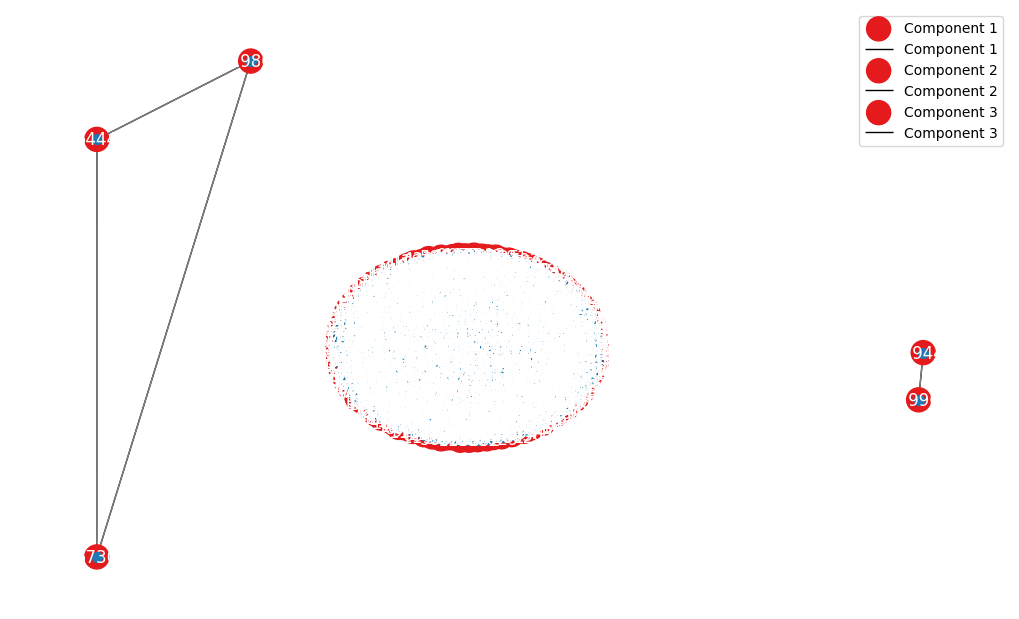

[{5204,
  5232,
  5233,
  5267,
  5274,
  5283,
  5291,
  5293,
  5308,
  5310,
  5349,
  5363,
  5372,
  5373,
  5391,
  5412,
  5420,
  5430,
  5432,
  5433,
  5443,
  5456,
  5467,
  5473,
  5501,
  5502,
  5504,
  5507,
  5522,
  5547,
  5550,
  5557,
  5559,
  5563,
  5570,
  5578,
  5620,
  5629,
  5641,
  5644,
  5666,
  5671,
  5674,
  5676,
  5699,
  5716,
  5722,
  5729,
  5735,
  5737,
  5738,
  5741,
  5754,
  5761,
  5765,
  5768,
  5772,
  5777,
  5797,
  5814,
  5816,
  5819,
  5827,
  5837,
  5844,
  5847,
  5868,
  5881,
  5882,
  5885,
  5898,
  5904,
  5930,
  5936,
  5937,
  5940,
  5945,
  5954,
  5970,
  5972,
  5984,
  5989,
  5999,
  6038,
  6040,
  6069,
  6086,
  6088,
  6091,
  6093,
  6110,
  6111,
  6120,
  6121,
  6122,
  6124,
  6134,
  6140,
  6191,
  6193,
  6205,
  6223,
  6236,
  6241,
  6244,
  6259,
  6261,
  6269,
  6276,
  6279,
  6280,
  6284,
  6287,
  6302,
  6306,
  6316,
  6317,
  6325,
  6327,
  6332,
  6344,
  6346,
  6353,
  6354,
  6361,


In [47]:
# Vemos los agentes de los distintos grupos:

show_connected_components(graph_w_q3)

In [48]:
# Vemos las matrices de decisión acordadas en cada grupo, y las utilidades globales por grupo:
final_matrices = np.unique(replace_similar_vectors(np.vectorize(round_3f)(agreements_w_q3[:,2000-1,:])),axis=0)
agreement_optimum_distance(agreements_w_q3, 2000, omega, omega)

Group: 0
Maximum value: -7.049737662168096e-15
Coordinates of the maximum: [0.11111115 0.55555556 0.11111115 0.11111115 0.11111115]
Distance between the vectors: 0.015449609990481243
Group: 1
Maximum value: -0.05844129799447674
Coordinates of the maximum: [0.16366933 0.1943945  0.22372925 0.24866733 0.26099382]
Distance between the vectors: 0.04110723840202177
Group: 2
Maximum value: -0.034386346832077495
Coordinates of the maximum: [0.48093852 0.28455156 0.09297332 0.09297332 0.09297332]
Distance between the vectors: 0.05216107050809133


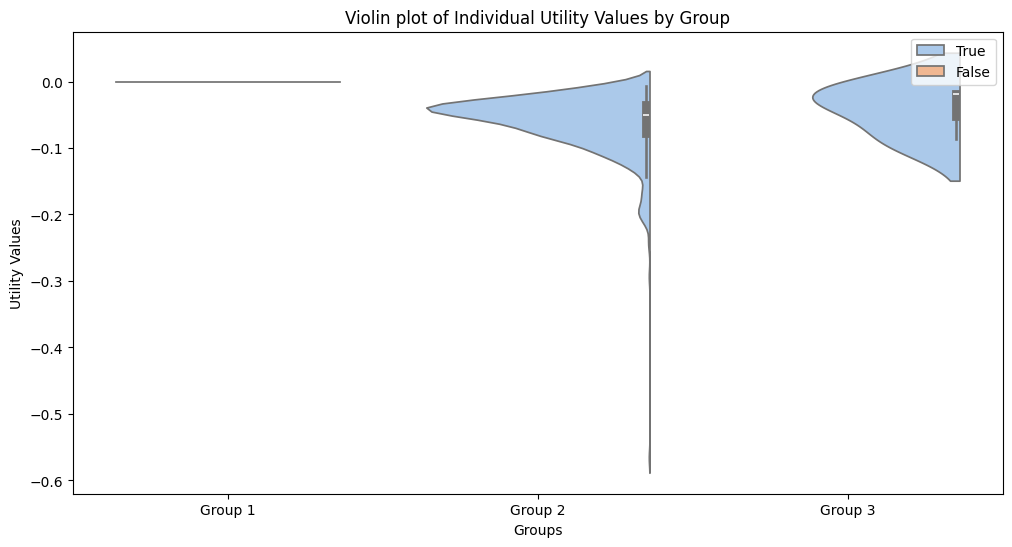

In [31]:
 # Veamos ahora las distribuciones de utilidades individuales de los agentes de cada grupo para ver si mejoran
# con respecto al caso de tener un único acuerdo:

utilidad_individual_grupo (agreements_w_q3, 2000, omega, omega)